# Personal Financial Planning

In [1]:
import numpy as np
import pandas as pd
from datetime import date
from collections import OrderedDict
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from IPython.core.display import display, HTML

# pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision',5)
pd.set_option('display.max_colwidth',100)
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
plt.style.use('ggplot')

## References

<https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.financial.html>  
<http://pbpython.com/amortization-model-revised.html>  
<http://www.financialmodellinghandbook.com/2014/03/15/sign-conventions/>  
<https://cleffinance.blogspot.com/2012/01/pv-pmt-when-to-put-negative.html>  


<https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/>  
<http://inmachineswetrust.com/posts/understanding-generators/#cell3>  
<https://github.com/NelisW/PythonNotesToSelf/blob/master/Generators.ipynb>


Discounted Cash Flow (DCF):  
https://www.investopedia.com/terms/d/dcf.asp  
https://www.wallstreetprep.com/knowledge/dcf-model-training-6-steps-building-dcf-model-excel/  
http://kaushik316-blog.logdown.com/posts/1651749-stock-valuation-with-python  
https://stackoverflow.com/questions/35849994/financial-modelling-with-pandas-dataframe  

Retirement advice
https://www.investopedia.com/terms/f/four-percent-rule.asp  



## Introduction

This notebook is a collection of calculations attempting to understand the positive (growth) and negative elements (cost and risk) in investments. It is not even considering dealing on the equity markets or other sophisticated financial instruments, but rather investigating small, longer-term, personal-scale  investments.

**A note on dates:**  The default start date in this notebook is 2000-01-01, mainly because it is easy to calculate the term remaining from a round number.  The date 0000-01-01 is not allowed in the Python code, so I start with the year 2000.

In South Africa we use ZAR (R) as monetary unit but I do not use the notation, simply because the same calculations apply irrespective of the monetary unit. South African inflation historically varied between 4% and 6% pa, managed by the central bank to target of 6% max.  Our mortgage bond loan interest rate vary from 8.5% to 10% depending on the age of the bond and the client's risk profile.  Numbers in your country will be different, adapt these calculations as necessary for your environment.

Terminology: 

A *mortgage* is a loan (usually secured by a bond) where the purpose of the loan is to purchase a fixed asset in the name of the borrower, but where the lender has the right to seize the asset if the borrower defaults on payment. The lender's right to seize falls away once the loan is fully repaid.

A *bond* is is a long term load agreement (by contract or certificate) whereby one party undertakes to repay the principal amount of the loan with interest by an agreed date. The term 'bond' is used in this document to imply a bond with a schedule of regular payments, usually monthly. In this notebook the terms bond and mortgage are use mostly equivalently.


## Simple Financial Calculations

The sign of a financial value is often confusing: some are positive others are negative. 

* When money is taken out from your pocket (outflows, you pay): use a negative sign.  
* When money is given to you (inflows, pay to you), use a positive sign.

When you borrow money, the capital principal is flowing in, it must be positice. The interest and payment due is flowing out, it must be negative.

When you withdraw from an investment, the capital flowed out when making the investment, hence it must be negative.
The withdrawal is flowing in, it must be positive.

In [2]:
Interest_Rate = 0.09
BondYears = 20
cyclesPerAnnum = 12
Principal = 1000000
start_date = (date(2000,1,1))

How large a monthly payment is required to repay bond?

In [3]:
pmt = np.pmt(Interest_Rate/cyclesPerAnnum, BondYears*cyclesPerAnnum, Principal)
print(f'Payment required {pmt}')

Payment required -8997.259558501702


How much interest or capital is paid in a specific period (a month in this case)

In [4]:
# Period/month for which to calculate
per = 240

# Calculate the interest
ipmt = np.ipmt(Interest_Rate/cyclesPerAnnum, per, BondYears*cyclesPerAnnum, Principal)

# Calculate the principal
ppmt = np.ppmt(Interest_Rate/cyclesPerAnnum, per, BondYears*cyclesPerAnnum, Principal)

print(f'Interest payment {ipmt}, capital repayment {ppmt}')


Interest payment -66.97711830150335, capital repayment -8930.282440200199


How large should the payment be to pay back a bond with regular payments?

In [5]:
np.pmt(rate=0.09/12, nper=5*12, pv=1000000, fv=0, when='end')

-20758.355226353873

Groth of a fixed amount of 1, for some years, compounded monthly at interest rates of 1 to 10%.


In [6]:
years = 30
monthsperyear = 12
df = pd.DataFrame()
df['Interest'] =  pd.Series(np.linspace(1,10,10)).transpose()
df['Future value'] =  np.fv(df['Interest']/(monthsperyear*100), nper=years*monthsperyear, pmt=0, pv=-1)
print(df)

   Interest  Future value
0       1.0       1.34969
1       2.0       1.82121
2       3.0       2.45684
3       4.0       3.31350
4       5.0       4.46774
5       6.0       6.02258
6       7.0       8.11650
7       8.0      10.93573
8       9.0      14.73058
9      10.0      19.83740


## Compound interest

http://umanitoba.ca/faculties/management/acctfin/stangeland/9.220/old/ratecon2.doc

The future value $F$ of a compounded interest present value $P$  is
$$
F = P \left(
1+\frac{i^{<m>}}{m}
\right)^m
$$
where $m$ is the number of accumulations and $i^{<m>}$ is the annual-expressed interest, with the understanding that it will be compounded $m$ times per year.

To convert between different compounding intervals note that the present value and future values must be the same, hence

$$
\left(
1+\frac{i^{<n>}}{n}
\right)^n =  \left(
1+\frac{i^{<m>}}{m}
\right)^m
$$

$$
i^{<n>}
 =  
n\left[\left(
1+\frac{i^{<m>}}{m}
\right)^{\frac{m}{n}}-1\right]
$$

In [7]:
def convertcompounded(n,m,imc,returnstr=False):
    inc = n * ( (1 + imc/m) ** (m/n) -1 )
    if returnstr:
        inc = f'Effective x{n} rate of {imc} compounded x{m} is {inc}'
    return inc    

The effective annual rate for a stated rate of 7.5% per year compounded quarterly:
$n=1$ and $m=4$, hence


In [8]:
print(convertcompounded(1,4,0.075,True))

Effective x1 rate of 0.075 compounded x4 is 0.07713586578369158


Fund managers take a commission as percentage of the *investment balance*.  One company, Coronation quote rates of up to 2% or even 3% on the investment value, compounded daily. What is the effect of daily compounding?  The difference may seem small but on large amounts of money, this difference can result a significant sum of money.

In [9]:
print(convertcompounded(1,365.25,0.02, True))
print(convertcompounded(1,365.25,0.03, True))

Effective x1 rate of 0.02 compounded x365.25 is 0.02020078141545234
Effective x1 rate of 0.03 compounded x365.25 is 0.030453264469993968


Investigate compounding in various directions

In [10]:
print(convertcompounded(1,365.25,0.095,True))
print(convertcompounded(1,12,0.095, True))
print('')
print(convertcompounded(1,365.25,0.06, True))
print(convertcompounded(1,12,0.06, True))
print(convertcompounded(365.25,1,0.06, True))
print(convertcompounded(12,1,0.06, True))


Effective x1 rate of 0.095 compounded x365.25 is 0.09964527177314153
Effective x1 rate of 0.095 compounded x12 is 0.09924758408100764

Effective x1 rate of 0.06 compounded x365.25 is 0.06183131426116972
Effective x1 rate of 0.06 compounded x12 is 0.06167781186449828
Effective x365.25 rate of 0.06 compounded x1 is 0.05827355623654029
Effective x12 rate of 0.06 compounded x1 is 0.05841060678411658


## Time Value of Money

Inflation erodes the buying power of money over time.  As long as your salary keeps track, or exceeds, of inflation, the erosion effect might not be very noticeable. However, if your salary increases slower than inflation, your buying power decreases with time.

From the table below (assuming compounded annually) it is evident that the value of money halves in 11.5 years if the inflation rate is 6%.

In [11]:
df = pd.DataFrame()
df['Inflation %'] =  np.linspace(3,15,13)
df['Years-to-half'] = -np.log(0.5)/np.log(1+df['Inflation %']/(100*12))/12
df

,Inflation %,Years-to-half
0,3.0,23.13378
1,4.0,17.35754
2,5.0,13.89180
3,6.0,11.58131
4,7.0,9.93096
5,8.0,8.69319
6,9.0,7.73048
7,10.0,6.96031
8,11.0,6.33018
9,12.0,5.80506


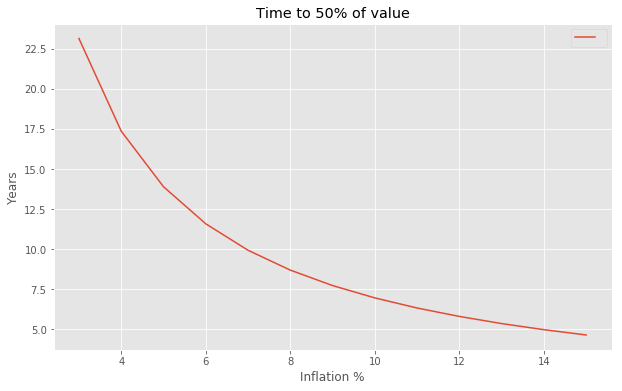

In [12]:
figsize(10,6)
fig, ax = plt.subplots(1, 1)
df.plot(x='Inflation %', y='Years-to-half', label=f'', ax=ax)
plt.title("Time to 50% of value");
plt.ylabel("Years");

## Mortgage Bond Amortisation Model

This model and code is taken from http://pbpython.com/amortization-model-revised.html. Moffit was looking for a way to do amortisation  calculations in Pandas without loops, but ended up using a generator function to do the looping.  The generator does a complete set of loops and then provides the answer to a Pandas DataFrame.   The power of Pandas is therefore not available during the loop, but it is available afterwards for analysis and plotting.  Moffit's original code is heavily refactored and cleaned up here. 

The algorithm to be executed at every time interval (e.g. every month) is as follows:

1. Calculate the interest on the balance, rounded to two decimals.
1. Calculate the payment as the smaller of the outstanding balance or the contractual payment amount (to account for a smaller payment in the last cycle).
1. Calculate the additional payment as the smaller of the outstanding balance or the fixed additional payment amount (to account for a smaller payment in the last cycle). 
1. Calculate the new balance by adding the interest and subtracting the two payments (but account for the signs of the financial values).
1. Calculate some housekeeping values like the date and payment cycle number.

It should be evident that the interest is calculated compound at each payment cycle, hence it adjusts at every payment cycle. 

The `amortise` function below is a Python generator function that provides iterative results for each time interval.  This generator is used to populate a Pandas DataFrame for subsequent anaysis.

In [13]:
def amortise(principal, interest_rate, bondyears, reqpayment, addpayment,start_date, cyclesPerAnnum,addpayrate=0,ID=''):
    """
    Calculate the amortization schedule given the loan details.

    :param principal: Amount borrowed
    :param interest_rate: The annual interest rate for this loan
    :param bondyears: Number of years for the loan
    :param reqpayment: Payment amount per period
    :param addpayment: Initial value of additional payments to be made each period.
    :param start_date: Start date for the loan.
    :param cyclesPerAnnum: Number of payment cycles in a year.
    :param addpayrate: Rate of increase in additional payment, calculated once per year.
    :param ID: String ID for this calculation.

    :return: 
        schedule: Amortization schedule as an Ordered Dictionary
    """

    # initialize the variables to keep track of the periods and running balances
    p = 1
    beg_balance = principal
    end_balance = principal
    currentyear = start_date.year

    while end_balance > 0:
        
        # Recalculate the interest based on the current balance
        interest = - round(((interest_rate/cyclesPerAnnum) * beg_balance), 2)
        
        # Determine payment based on whether or not this period will pay off the loan
        reqpayment = - min(-reqpayment, beg_balance - interest)
        
        # Ensure additional payment gets adjusted if the loan is being paid off
        addpayment = - min(-addpayment, beg_balance - interest + reqpayment)
        
        end_balance = beg_balance - interest  + reqpayment  + addpayment

        yield OrderedDict([('Month',start_date),
                           ('Period', p),
                           ('Begin Balance', beg_balance),
                           ('ReqPayment', reqpayment),
                           ('Principal', principal),
                           ('InterestRate', interest_rate),
                           ('Interest', interest),
                           ('AddPayment', addpayment),
                           ('End Balance', end_balance),
                           ('ID', ID),
                          ])
        
        # Increment the counter, balance and date
        p += 1
        
        if cyclesPerAnnum == 12:
            start_date += relativedelta(months=1)
        elif  cyclesPerAnnum == 365.25:
            start_date += relativedelta(days=1)
        else:
            print(f'Unknown cyclesPerAnnum = {cyclesPerAnnum}')
            return None

        beg_balance = end_balance
        
        # only increase the additional payment once per year
        if start_date.year != currentyear:
            currentyear = start_date.year
            addpayment *= 1 + addpayrate


Confirm that the `amortize` function is a generator:

In [14]:
amortise(principal=10000, interest_rate=.03, bondyears=5, reqpayment=-400, addpayment=0, start_date=date(2000, 1,1), cyclesPerAnnum=12)

<generator object amortise at 0x0000000009601F10>

Next create a wrapper function to use `amortize` to fill a Pandas DataFrame.  This function primarily cleans up the table and provides summary stats so it is easy to compare various scenarios.  See the function docstring for the parameters and conventions to be used.

Note that the additional payment can be specified as a money value or as a fraction  
    of the required payment. Complex value notation is used where the money value 
    is the real component (e.g., -2300, negative value) and the fraction value is 
    the imaginary component (e.g., .02j, positive fraction). If the (negative) real component 
    (money value) is given the (positive) imaginary component (fraction value) is ignored.



In [15]:
def amortisation_table(principal, interest_rate, bondyears,reqpayment,
                       addpayment=0, cyclesPerAnnum=12, start_date=(date(2000,1,1)),addpayrate=0,ID=''):
    """
    Calculate the amortization schedule given the loan details as well as summary stats for the loan

    :param principal: Amount borrowed (positive)
    :param interest_rate: The *annual* interest rate for this loan (positive)
    :param bondyears: Number of years for the loan (positive)
    :param reqpayment: minimum required payment to meet the term requirements (negative)
    :param cyclesPerAnnum (optional): Number of payment cycles in a year. Default 12.
    :param addpayment (optional): Additional payments to be made each period. ** See note below. Default 0. (negative)
    :param start_date (optional): Start date. Default 2000-01-01 if none provided
    :param addpayrate: Rate of increase in additional payment, calculated once per year.

    The additional payment can be specified as a money value or as a fraction  
    of the required payment. Complex value notation is used where the money value 
    is the real component (e.g., -2300, negative value) and the fraction value is 
    the imaginary component (e.g., .02j, positive fraction). If the (negative) real component 
    (money value) is given the (positive) imaginary component (fraction value) is ignored.

    :return: 
        schedule: Amortization schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the payoff information
    """
    
    if np.real(addpayment) != 0:
        addpayment = np.real(addpayment)
    elif np.imag(addpayment) != 0:
             addpayment = reqpayment * np.imag(addpayment )
    else:
        addpayment = 0
    
    # Generate the schedule 
    schedule = pd.DataFrame(amortise(principal, interest_rate, bondyears, reqpayment,
                                     addpayment, start_date, cyclesPerAnnum,addpayrate=addpayrate,
                                    ID=ID))
    
    if schedule.empty:
        stats = pd.Series([0,start_date, 0, interest_rate,
                   0, 0, 0,0,0,ID],
                   index=["Principal","Payoff Date", "Num Payments", "Interest Rate", "BondYears", 
                         "ReqPayment", "AddPayment", "Addpayrate","Total Interest",ID])

        return None, stats

    # reorder the columns
    schedule = schedule[["Period", "Month", "Begin Balance", "ReqPayment","AddPayment",
                         "Interest", "End Balance",'Principal','InterestRate','ID']]

    # Convert to a pandas datetime object to make subsequent calcs easier
    schedule["Month"] = pd.to_datetime(schedule["Month"])
    
    #Create a summary statistics table
    payoff_date = schedule["Month"].iloc[-1]
    stats = pd.Series([principal,payoff_date, schedule["Period"].count(), interest_rate,
                       bondyears, reqpayment, addpayment,addpayrate,
                       schedule["Interest"].sum(),ID],
                       index=["Principal","Payoff Date", "Num Payments", "Interest Rate", "BondYears", 
                             "ReqPayment", "AddPayment", "Addpayrate","Total Interest","ID"])
    
    return schedule, stats

Example showing how to call the function

In [16]:
principal = 1000000
interest_rate = 0.09
bondyears = 20
cyclesPerAnnum = 12
reqpayment = round(np.pmt(interest_rate/cyclesPerAnnum, bondyears*cyclesPerAnnum, principal), 2)

df, stats = amortisation_table(
    principal=principal, 
    interest_rate=interest_rate, 
    bondyears=bondyears, 
    reqpayment = reqpayment,
    addpayment = 0.02j,
    cyclesPerAnnum=cyclesPerAnnum, 
    start_date=date(2000, 1,1),
    addpayrate=0.0,
    ID=""
    )

The `stats` DataFrame provide a summary of the total contract, showing the key values, including the required payment, additional payment (if provided) and the total interest over the full term of the contract.  Note that the principal value is positive (inflow) and the payments and interest are negative (outflow).

In [17]:
stats

Principal                     1000000
Payoff Date       2018-12-01 00:00:00
Num Payments                      228
Interest Rate                    0.09
BondYears                          20
ReqPayment                    -8997.3
AddPayment                    -179.95
Addpayrate                          0
Total Interest            -1.0875e+06
ID                                   
dtype: object

The following table shows the first few and the last few cycles of the schedule. Note that in the first month 83% of the payment is interest: only 17% of the payment is applied towards reducing the loan amount.  Towards the end of the term the interest reduces to a small percentage.

In [18]:
df['IntPercent'] = 100 * df['Interest'] / df['ReqPayment']
display(HTML(df.head().to_html()))
display(HTML(df.tail().to_html()))


,Period,Month,Begin Balance,ReqPayment,AddPayment,Interest,End Balance,Principal,InterestRate,ID,IntPercent
0,1,2000-01-01,1000000.0000,-8997.26,-179.9452,-7500.00,998322.7948,1000000,0.09,,83.35871
1,2,2000-02-01,998322.7948,-8997.26,-179.9452,-7487.42,996633.0096,1000000,0.09,,83.21889
2,3,2000-03-01,996633.0096,-8997.26,-179.9452,-7474.75,994930.5544,1000000,0.09,,83.07807
3,4,2000-04-01,994930.5544,-8997.26,-179.9452,-7461.98,993215.3292,1000000,0.09,,82.93614
4,5,2000-05-01,993215.3292,-8997.26,-179.9452,-7449.11,991487.2340,1000000,0.09,,82.79309


,Period,Month,Begin Balance,ReqPayment,AddPayment,Interest,End Balance,Principal,InterestRate,ID,IntPercent
223,224,2018-08-01,40116.8204,-8997.2600,-179.9452,-300.88,31240.4952,1000000,0.09,,3.34413
224,225,2018-09-01,31240.4952,-8997.2600,-179.9452,-234.30,22297.5900,1000000,0.09,,2.60413
225,226,2018-10-01,22297.5900,-8997.2600,-179.9452,-167.23,13287.6148,1000000,0.09,,1.85868
226,227,2018-11-01,13287.6148,-8997.2600,-179.9452,-99.66,4210.0696,1000000,0.09,,1.10767
227,228,2018-12-01,4210.0696,-4241.6496,-0.0000,-31.58,0.0000,1000000,0.09,,0.74452


## Interest on Bond vs Set-Up Costs

Is it worth borrowing money for an investment property with the objective of writing interest off against tax?
It would seem to make sense to invest some cash and then take out a bond to cover the remainder of the purchase price.
The rent is an income and hence is taxable, however the bond interest is an expense and must be subtracted from the rent income before tax.
So in principle, it seems like a good idea to take out a bond and get the tax benefit on the interest.  In effect the tax man pays a portion of the interest.

This model increases the rent from a starting value only once per year.

Observe the effect of the number of years from 5 to 20, and the effect of changing the tax rate.

This analysis presently ignores the effect of time value of money.  



In [19]:
# to calculate the annually increased value into a DataFrame
def annualIncrease(value, increasepyear, numcycles, date, colhead='Value'):
    """The `annualIncrease` function calculates the value increasing 
    once per year (not every month) at the stated annual rate.
    """

    p = 1
    currentyear = date.year

    while p < numcycles + 1:      
        yield OrderedDict([('Month',date),('Period', p),(colhead, value)])  
        # Increment the counter, balance and date
        p += 1
        date += relativedelta(months=1)
        # only increase the value once per year
        if date.year != currentyear:
            currentyear = date.year
            value *= 1 + increasepyear
                           

def annIncreaseTable(value, increasepyear, numcycles, start_date=date(2000,1,1),colhead='Rent'):
    
    # Generate the rent income schedule 
    rischedule = pd.DataFrame(annualIncrease(value, increasepyear, numcycles,start_date,colhead=colhead))
    
    # Convert to a pandas datetime object to make subsequent calcs easier
    rischedule["Month"] = pd.to_datetime(rischedule["Month"])

    return rischedule

In [20]:
# to evaluate the tax benefits
def bondtaxsavingsanalysis(principal,interest_rate,bondyears,taxrate,rentpmonth,
                           increasepyear,cyclesPerAnnum=12,addpayment=0,addpayrate=0):
    
    reqpayment = round(np.pmt(interest_rate/cyclesPerAnnum, bondyears*cyclesPerAnnum, principal), 2)

    # calculate the mortgage 
    df, stats = amortisation_table(
        principal=principal, 
        interest_rate=interest_rate, 
        bondyears=bondyears, 
        reqpayment = reqpayment,
        addpayment=addpayment,
        cyclesPerAnnum=cyclesPerAnnum, 
        start_date=date(2000, 1,1),
        addpayrate=addpayrate)

    numcycles = stats['Num Payments']
    rischedule = annIncreaseTable(value=rentpmonth, increasepyear=increasepyear, numcycles=numcycles)
    # Now merge the bond table with the rent income table
    dfc = df.copy().drop(["ReqPayment","AddPayment","Begin Balance"],axis=1)
    dfc = dfc.merge(rischedule.drop(["Month"],axis=1), on='Period')
    
    # number of payments
    dfc['NumPay'] = stats['Num Payments']
    
    # save tax for later
    dfc['TaxRate'] = taxrate
    
    # tax and net income if **NO** bond present
    dfc['TaxNoInter'] = - taxrate * (dfc['Rent'])
    # can't get tax back
    dfc['TaxNoInter'][dfc['TaxNoInter'] > 0] = 0
    dfc['IncomeNoInter'] = dfc['Rent'] + dfc['TaxNoInter']

    # tax and net income if bond present
    dfc['TaxWithInter'] = - taxrate * (dfc['Rent'] + dfc['Interest'])
    # can't get tax back
    dfc['TaxWithInter'][dfc['TaxWithInter'] > 0] = 0
    dfc['IncomeWithInter'] = dfc['Rent'] + dfc['TaxWithInter']

    # net benefit
    dfc['BondBenefit'] = dfc['IncomeWithInter'] - dfc['IncomeNoInter']

    #Create a summary statistics table
    nistats = pd.Series([stats['Principal'],stats['Interest Rate'],
                         stats['ReqPayment'],stats['AddPayment'],dfc["Period"].count(),
                         rentpmonth,  increasepyear,
                         taxrate,
                         dfc["Rent"].sum(),
                         dfc["TaxNoInter"].sum(),
                         dfc["IncomeNoInter"].sum(),
                         dfc["TaxWithInter"].sum(),
                         dfc["IncomeWithInter"].sum(),
                         dfc["BondBenefit"].sum(),
                         100 * dfc["BondBenefit"].sum()/dfc["Rent"].sum(),
                        ],
                       index=["Bond","Interest Rate",
                              "ReqPayment","AddPayment","Num Payments",
                              "InitRent",  "RentIncrease",
                              "TaxRate",
                              "Total Rent",
                              "TaxNoInter",
                              "IncomeNoInter",
                              "TaxWithInter",
                              "IncomeWithInter",
                              "BondBenefit",
                              "Benefit/Rent %",
                             ])

    if False:
        figsize(12,8)
        fig, ax = plt.subplots(1, 1)
        # for scenario in scenarios.keys():
        #     schedules[scenario].plot(x='Month', y='End Balance', label=f'{scenario}', ax=ax)
        dfc.plot(x='Month',y='Rent', label='Rent', ax=ax)    
        dfc.plot(x='Month',y='Interest', label='Interest', ax=ax)    
        dfc.plot(x='Month',y='TaxNoInter', label='TaxNoInter', ax=ax)    
        dfc.plot(x='Month',y='TaxWithInter', label='TaxWithInter', ax=ax)    
        plt.title("Repayment Timelines");
        plt.ylabel("Value");
        plt.xlabel("Time");
        
    return dfc,nistats

In [21]:
# bond values
principal = 500000
interest_rate = 0.09

# tax rate and rental income 
rentpmonth = 4500
increasepyear = 0.06

# experiment with variations
dfSch = pd.DataFrame()
dfSum = pd.DataFrame()

for bondyears in [4,5,20]:
    for taxrate in [0.2, 0.33, 0.42]:
        dfc,nistats = bondtaxsavingsanalysis(principal=principal,
                            interest_rate=interest_rate,bondyears=bondyears,
                            taxrate=taxrate,rentpmonth=rentpmonth,
                            increasepyear=increasepyear)
        # append all cases in to single df, must be filtered later
        dfSch = dfSch.append(dfc)
        # append all summaries into single df
        dfSum = dfSum.append(nistats,ignore_index=True)

The `dfSch` data frame contains all the month's status' for all the scenarios in one data frame.  To plot or analyse you must apply a filter to select only the required `NumPay` and `TaxRate` values.

In [22]:
display(HTML(dfSch.head().to_html()))
display(HTML(dfSch.tail().to_html()))

,Period,Month,Interest,End Balance,Principal,InterestRate,ID,Rent,NumPay,TaxRate,TaxNoInter,IncomeNoInter,TaxWithInter,IncomeWithInter,BondBenefit
0,1,2000-01-01,-3750.00,491307.48,500000,0.09,,4500.0,49,0.2,-900.0,3600.0,-150.000,4350.000,750.000
1,2,2000-02-01,-3684.81,482549.77,500000,0.09,,4500.0,49,0.2,-900.0,3600.0,-163.038,4336.962,736.962
2,3,2000-03-01,-3619.12,473726.37,500000,0.09,,4500.0,49,0.2,-900.0,3600.0,-176.176,4323.824,723.824
3,4,2000-04-01,-3552.95,464836.80,500000,0.09,,4500.0,49,0.2,-900.0,3600.0,-189.410,4310.590,710.590
4,5,2000-05-01,-3486.28,455880.56,500000,0.09,,4500.0,49,0.2,-900.0,3600.0,-202.744,4297.256,697.256


,Period,Month,Interest,End Balance,Principal,InterestRate,ID,Rent,NumPay,TaxRate,TaxNoInter,IncomeNoInter,TaxWithInter,IncomeWithInter,BondBenefit
235,236,2019-08-01,-164.97,17661.78,500000,0.09,,13615.19776,240,0.42,-5718.38306,7896.8147,-5649.09566,7966.1021,69.2874
236,237,2019-09-01,-132.46,13295.61,500000,0.09,,13615.19776,240,0.42,-5718.38306,7896.8147,-5662.74986,7952.4479,55.6332
237,238,2019-10-01,-99.72,8896.70,500000,0.09,,13615.19776,240,0.42,-5718.38306,7896.8147,-5676.50066,7938.6971,41.8824
238,239,2019-11-01,-66.73,4464.80,500000,0.09,,13615.19776,240,0.42,-5718.38306,7896.8147,-5690.35646,7924.8413,28.0266
239,240,2019-12-01,-33.49,0.00,500000,0.09,,13615.19776,240,0.42,-5718.38306,7896.8147,-5704.31726,7910.8805,14.0658


The final conclusion is as follows:

In [23]:
# to compare different bond and tax rate scenarios
drops = ['AddPayment','Bond','IncomeNoInter','IncomeWithInter',
         'InitRent','ReqPayment','TaxNoInter','TaxWithInter','Total Rent','Interest Rate']
df = dfSum.drop(drops,axis=1)
df = df[['Num Payments','TaxRate','BondBenefit','Benefit/Rent %']]
# display(HTML(df.to_html(index=False)))

The following table shows the savings (BondBenefit) by claiming the interest back from tax:

In [24]:
dfp = pd.pivot_table(df, index=['Num Payments'],values=['BondBenefit'],columns=['TaxRate'])
display(HTML(dfp.to_html(index=True)))


It seems that for bond periods of around 4 to 5 years, the savings benefit is only significant at high tax rates: the cost of setting up the bond may consume a substantial portion of the actual savings. As expected, at higher tax rates the income benefit is more. The savings expressed as percentage of rental income before tax and interest is not very high.

However, this calculation is not completely accurate:
1. To repay the bond over five years you need to pay a significant additional amount. There is a cost to this additional payment not accounted for this simple calculation.
1. The time value of money is not included here.

## Bond Repayment Studies

Define a few standard utility functions

In [25]:
def plot_balance(scenarios):
    """Plot the remaining balance of all scenarios
    """
    figsize(12,8)
    fig, ax = plt.subplots(1, 1)
    for scenario in scenarios.keys():
        schedules[scenario].plot(x='Month', y='End Balance', label=f'{scenario}', ax=ax)
    plt.title("Repayment Timelines");
    plt.ylabel("Balance");

In [26]:
def plot_annual_interest(schedule, stats):
    """Plot the annual interest of all scenarios
    """
    ys = {}
    labels = {}
    for scenario in scenarios.keys():
        ys[scenario],labels[scenario] = annual_interest(schedules[scenario], stats[scenario])

    dfai = pd.concat([ys[scenario] for scenario in ys.keys()], axis=1)
    # print(dfai)

    figsize(12,8)
    fig, ax = plt.subplots(1, 1)
    dfai.plot(kind="bar", ax=ax)

    plt.legend([labels[scenario] for scenario in labels.keys()], loc=1, prop={'size':10})
    plt.title("Interest Payments");

In [27]:
def annual_interest(schedule, stats):
    """Create a dataframe with annual interest totals, and a descriptive label
    """
    annint = schedule.set_index('Month')['Interest'].resample("A").sum().reset_index()
    annint["Year"] = annint["Month"].dt.year
    annint.set_index('Year', inplace=True)
    annint.drop('Month', 1, inplace=True)
    label="{} years at {}% with additional payment of {:.0f}".format(stats['BondYears'], stats['Interest Rate']*100, stats['AddPayment'])
    return annint, label



In [28]:
def calc_scenarios(scenarios,cyclesPerAnnum=12,paymentSign=1):
    """Given a scenario dictionary calculate bond schedules and statistics
    """
    schedules = {}
    stats = {}
    
    for scenario in scenarios.keys():
        if 'reqPayment' not in scenarios[scenario].keys():
            scenarios[scenario]['reqPayment'] = \
                paymentSign * round(np.pmt(scenarios[scenario]['intr'] / cyclesPerAnnum, 
                              scenarios[scenario]['years'] * cyclesPerAnnum, 
                              scenarios[scenario]['princ']), 2);
       
        schedules[scenario], stats[scenario] = amortisation_table(
                        scenarios[scenario]['princ'], 
                        scenarios[scenario]['intr'], 
                        scenarios[scenario]['years'], 
                        scenarios[scenario]['reqPayment'], 
                        scenarios[scenario]['addPayment'],
                        cyclesPerAnnum=12
                    );
    return schedules,stats


### Fixed scenario, different additional payments

This calculation shows how the bond/mortgage term can be shortened by adding a fixed percentage (0%, 2%, 10%, 20%, or 30%) to the required payment.  By increasing the payment the term is shortened significantly and the total money paid is much reduced.

In [29]:
scenarios = {
    '0.04%, add=0%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0,'years':20},
    '0.04%, add=2%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.02j,'years':20},
    '0.04%, add=10%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.1j,'years':20},
    '0.04%, add=20%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.2j,'years':20},
    '0.04%, add=30%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.3j,'years':20},
}
        
schedules,stats = calc_scenarios(scenarios) 

In [30]:
dfstats = pd.DataFrame([stats[key] for key in stats.keys()])
dfstats['Years'] = dfstats['Num Payments'] / 12
dfstats['Additional % payment'] = 100 * dfstats['AddPayment'] / dfstats['ReqPayment']
dfstats['TotalPaid/Principal'] = 1 - dfstats['Total Interest'] / dfstats['Principal']
display(HTML(dfstats.to_html()))

,Principal,Payoff Date,Num Payments,Interest Rate,BondYears,ReqPayment,AddPayment,Addpayrate,Total Interest,ID,Years,Additional % payment,TotalPaid/Principal
0,1000000,2019-12-01,240,0.09,20,-8997.26,0.0000,0,-1159342.10,,20.00000,-0.0,2.15934
1,1000000,2018-12-01,228,0.09,20,-8997.26,-179.9452,0,-1087467.23,,19.00000,2.0,2.08747
2,1000000,2015-10-01,190,0.09,20,-8997.26,-899.7260,0,-878228.77,,15.83333,10.0,1.87823
3,1000000,2013-03-01,159,0.09,20,-8997.26,-1799.4520,0,-714178.37,,13.25000,20.0,1.71418
4,1000000,2011-06-01,138,0.09,20,-8997.26,-2699.1780,0,-604582.36,,11.50000,30.0,1.60458


Notice how the term of the contract dramatically shortens if a fixed additional payment is made. If you pay 30% extra over and above the required payment, the term shortens from 20 years to just under 12 years.

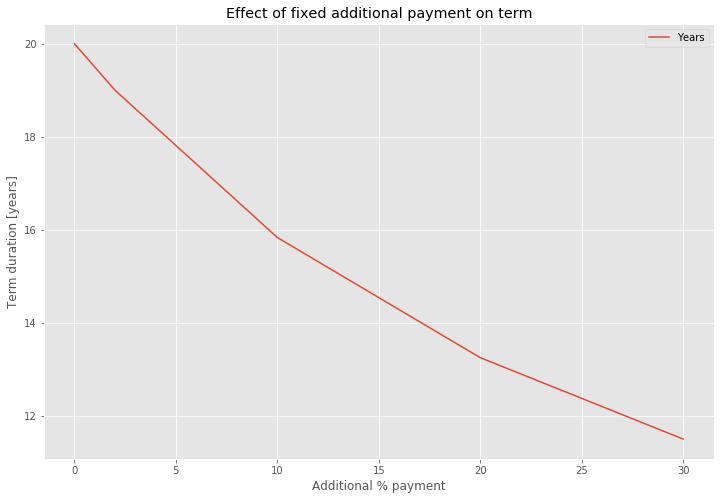

In [31]:
figsize(12,8)
fig, ax = plt.subplots(1, 1)
dfstats.plot(x='Additional % payment', y='Years', ax=ax)
plt.title("Effect of fixed additional payment on term");
plt.ylabel("Term duration [years]");


The next graph shows the total money repaid on the contract as a function of additional payment.  

If no additional payment is made, the total amount paid back over the full term of the contract is 2.16 times the initial loan principal amount.

Notice how the interest dramatically reduces if a fixed additional payment is made. 
If you pay 30% extra over and above the required payment, the total amount paid back over the full term of the contract is 1.6 times the initial loan principal amount.

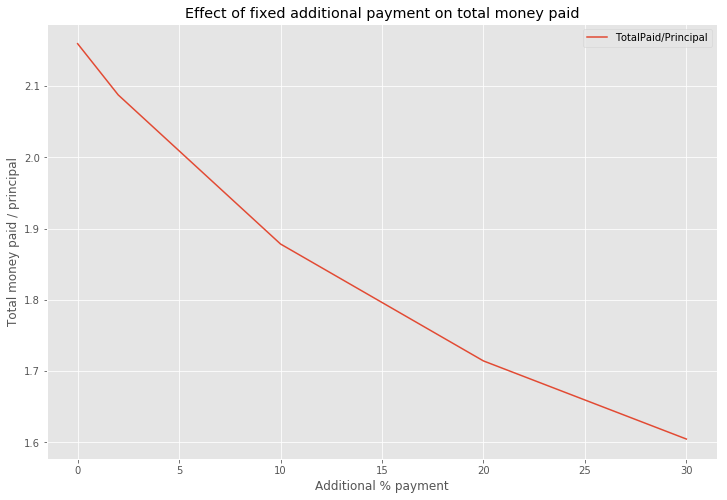

In [32]:
figsize(12,8)
fig, ax = plt.subplots(1, 1)
dfstats.plot(x='Additional % payment', y='TotalPaid/Principal', ax=ax)
plt.title("Effect of fixed additional payment on total money paid");
plt.ylabel("Total money paid / principal");


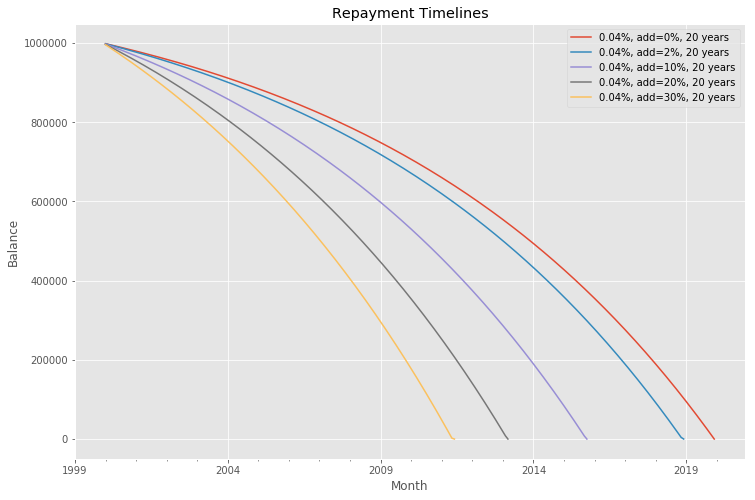

In [33]:
plot_balance(scenarios)

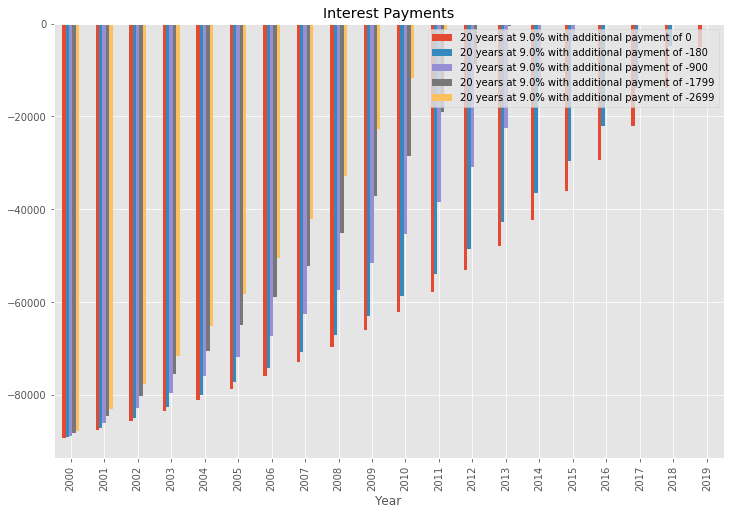

In [34]:
plot_annual_interest(schedules, stats)   

## Rental Property Analysis

Study the cash flow over some extended period `calcyears` when buying a property against a bonded loan for the purpose of renting it out. The loan can be fully repaid in `bondyears`, before the end of the extended study period. Hence in the initial `bondyears` the loan requires interest payment (as a cost against the property) and after the `bondyears` period, the interest is zero, with the property returning a positive inflow of cash.  The intent is to determine the effect of bond duration on the total cash flow over the extended period.

Given the loan amount, interest rate and other parameters, an additional payment is required to repay the loan at the end of the `bondyears` period. Hence, in the initial years the investment is cash flow negative as the loan is repaid.  The investment should become cash flow positive after the loan in repaid.  The question remains: over the extended analysis period, **what was the net cumulative cash flow?**  The smaller (or more negative) the net cumulative cash flow is, the poorer investment is.

For simplicity we assume that the additional loan down payment funds are free (no costs or losses in removing the funds from other investments).
We also assume that the tax is payable every month, whereas in real life, the tax is only payable on predetermined dates (once or twice per year).
The model allows for annual increase in rental income, rates and taxes, renting agency fees and levies. The tax benefit is also applied.

The model assumes that the rental income is paid towards depleting the bond (not removed as personal income).

The costs include: 
1. bond interest, cost of the loan, expressed as a percentage on outstanding balance.
1. maintenance, fix and maintain the property, expressed as percentage of rental income. Reasonable values should be 2% to 10% depending on the condition of the property. 
If it is a full-title property there should be no levies, but this maintenance cost should be higher.
If it is a sectional-title property there should be higher levies, but this maintenance cost should be lower, because much of the maintenance is already included in the levy.
1. renting agents fee (if applicable), expressed as percentage of rental income. It is convenient to use an agency to find renters and manage the rent agreement. Normally this is 7% to 10% of the rent.
1. levies (if applicable), if the property is part of a sectional title scheme.  This can also be used to include any costs to maintain buildings, gardens, etc.
1. Local government statutory rates and taxes.
1. risk of less than 100% occupancy, defaulting rent payments, damage to property, other other expenses arising from poor tenant behaviour.

**Note** the time value of money is not accounted for here, hence the situation is actually worse than what this analysis shows: we use expensive money to repay the loan early and earn cheap money positive cash flow later.

**Note** this analysis only considers the rental income and costs against this income.  The **capital growth is not considered at all in the present analysis**, it will be added later.

The calculation is as follows:

![](images/bond-optimisation.png)


In [35]:
# to calcuate the cash flow for a rental property

def rentalProperty(principal,interest_rate,bondyears,calcyears,rentpmonth,rentpermonthInc,agentPcnt,levy,
                   ratesnt,levyInc,ratesntInc,maintPcnt,
                   taxrate,riskPcnt=0,cyclesPerAnnum=12,doplot=False,start_date=date(2000, 1,1),
                   ID=''):
    
    reqpayment = round(np.pmt(rate=interest_rate/cyclesPerAnnum, nper=bondyears*cyclesPerAnnum, 
                              pv=principal, fv=0, when='end'),2)
   
    
    df, stats = amortisation_table(
        principal=principal, 
        interest_rate=interest_rate, 
        bondyears=bondyears, 
        reqpayment = reqpayment,
        cyclesPerAnnum=cyclesPerAnnum,
        start_date=start_date,
        ID=ID,
        )
    numcycles = stats['Num Payments']
    
    # if loan is paid off before end of the term add zero-content lines
    if numcycles < calcyears * cyclesPerAnnum + 1:
        if numcycles == 0:
            df = pd.DataFrame()
            curdate = start_date
        else:
            curdate = stats['Payoff Date']
        while numcycles < calcyears * cyclesPerAnnum + 1:
            # add additional lines with zero interest costs 
            dic =  OrderedDict([('Month',curdate),
                           ('Period', numcycles+1),
                           ('Begin Balance', 0),
                           ('ReqPayment', 0),
                           ('Principal', stats['Principal']),
                           ('InterestRate', df['InterestRate'].mean()),
                           ('Interest', 0),
                           ('AddPayment', 0),
                           ('End Balance', 0),
                           ('ID',ID),
                               ],)
            df = df.append(pd.DataFrame(dic, index=[numcycles]),sort=True)
            curdate += relativedelta(months=1)
            numcycles += 1

    # rent income
    rischedule = annIncreaseTable(value=rentpmonth, increasepyear=rentpermonthInc, numcycles=numcycles)
    # costs
    levyschedule = annIncreaseTable(value=levy, increasepyear=levyInc, numcycles=numcycles,colhead='Levy')
    ratesntschedule = annIncreaseTable(value=ratesnt, increasepyear=ratesntInc, numcycles=numcycles,colhead='RatesT')


    # Now merge the bond table with the rent income table
    dfc = df.copy().drop(["AddPayment"],axis=1)
    dfc = dfc.merge(rischedule.drop(["Month"],axis=1), on='Period')
    dfc = dfc.merge(levyschedule.drop(["Month"],axis=1), on='Period')
    dfc = dfc.merge(ratesntschedule.drop(["Month"],axis=1), on='Period')

    #agent fees
    dfc['Agent'] = -agentPcnt * dfc['Rent']
    
    #maintenance
    dfc['Maint'] = -maintPcnt * dfc['Rent']

    #risk
    dfc['Risk'] = -riskPcnt * dfc['Rent']
    
    # number of payments
    dfc['NumPay'] = stats['Num Payments']

    # save tax for later
    dfc['TaxRate'] = taxrate
    
    #costs
    dfc['Costs'] = dfc['Interest']+ dfc['Agent']+ dfc['Levy']+ dfc['RatesT'] + dfc['Maint'] + dfc['Risk']
    
    # rent after cost before tax
    dfc['RentAfterCosts'] = dfc['Rent'] +   dfc['Costs']
    
    # tax and net income if bond present; can't get tax back on losses
    dfc['TaxRate'] =  taxrate 
    dfc['Tax'] = - taxrate * (dfc['RentAfterCosts'] )
    dfc['Tax'][dfc['Tax'] > 0] = 0
    
    dfc['Costs+Tax'] = dfc['Tax'] + dfc['Costs']
    dfc['Income'] = dfc['Rent'] + dfc['Costs+Tax'] 
    dfc['CashFlow'] = dfc['ReqPayment'] + dfc['Income']

    dfc['RentAfterCostsFrac'] = dfc['RentAfterCosts'] / dfc['Rent']
   
    
    #Create a summary statistics table
    istats = pd.Series([stats['Principal'],stats['Interest Rate'],stats['BondYears'],
                        stats['ReqPayment'],stats['Total Interest'],
                        dfc['CashFlow'].sum(),dfc["Period"].count(),
                        calcyears,
                         rentpmonth,  rentpermonthInc,
                         levy,  levyInc,
                         ratesnt,  ratesntInc,
                         taxrate,agentPcnt,
                         dfc['Maint'].sum(),maintPcnt,
                         dfc['Risk'].sum(),riskPcnt,
                         dfc["Rent"].sum(),
                         dfc["Tax"].sum(),
                         dfc["Income"].sum(),
                         dfc['RentAfterCosts'].sum() / dfc['Rent'].sum(),
                         ID,
                        ],
                       index=["Bond","Interest Rate","BondYears",
                              "ReqPaymentMonth","TotalInterest",
                              "CumCashFlow","Num Payments",
                              "CalcYears",
                              "InitRent",  "RentIncrease",
                              "InitLevy",  "LevyIncrease",
                              "InitR&T",  "R&TIncrease",
                              "TaxRate","AgentPcnt",
                              "Maint","MaintPcnt",
                              "Risk","RiskPcnt",
                              "Total Rent",
                              "Tax",
                              "Income",
                              "RentAfterCostsB4TaxFrac",
                              "ID",
                             ])


    if doplot:
        plotrentalpropcashflowtimeline(dfc)        
        plotrentalpropeffectiverent(dfc)        

#     display(HTML(dfc.head().to_html()))
#     display(HTML(dfc.tail().to_html()))
#     stats
    return dfc,istats


In [36]:
def plotrentalpropcashflowtimeline(dfc):
    import matplotlib.pyplot as plt
    figsize(12,8)
    fig, axes = plt.subplots(nrows=1, ncols=1)
    taxrate = dfc['TaxRate'].mean()
    interest_rate = dfc['InterestRate'].mean()
    ID = dfc.iloc[0]['ID']
    dfc.plot(x='Month',y='Rent', label='Gross rent income', ax=axes)    
    dfc.plot(x='Month',y='RentAfterCosts', label='Net rent income after costs before tax', ax=axes)    
    dfc.plot(x='Month',y='Interest', label=f'Interest={interest_rate:.4f}', ax=axes)    
    dfc.plot(x='Month',y='Costs+Tax', label='Costs+Tax', ax=axes)  
    dfc.plot(x='Month',y='CashFlow', label='Cash flow', ax=axes)    
    dfc.plot(x='Month',y='Tax', label=f'Tax={taxrate:.3f}', ax=axes)    
    plt.title(f"{ID} Rental property cash flow timelines");
    plt.ylabel("Value");
    plt.xlabel("Time");


def plotrentalpropeffectiverent(dfc):
    import matplotlib.pyplot as plt
    
    ID = dfc.iloc[0]['ID']
    meanval = dfc['RentAfterCosts'].sum() / dfc['Rent'].sum()
    figsize(12,8)
    fig, axes = plt.subplots(nrows=1, ncols=1)
    dfc.plot(x='Month',y='RentAfterCostsFrac', label='Rent-after-costs-before-tax / Rent', ax=axes,ylim=[0,1])    
    plt.title(f"{ID} Effective rent after cost before tax, mean value={meanval:.3f}");
    plt.ylabel("Fraction");
    plt.xlabel("Time");    

**Note** The parameters used in the following investigation are not optimal in the sense that the rent income is poor relative to the cost of the property.
It may be possible to get half of this rent income (3000) for some properties costing a quarter of the value considered here (250k).



The parameters used in the analysis are as follows:

In [37]:
principal = 1000000
interest_rate = 0.097
bondyears = 5
calcyears = 20
rentpmonth = 7000
rentpermonthInc = 0.06
agentPcnt = 0.08
maintPcnt = 0.03
riskPcnt = 0.01
levy = -600
ratesnt = -600
levyInc = 0.06
ratesntInc = 0.06
taxrate = 0.33

dfc,istats = rentalProperty(principal=principal,interest_rate=interest_rate,
                bondyears=bondyears,calcyears=calcyears,rentpmonth=rentpmonth,rentpermonthInc=rentpermonthInc,
                agentPcnt=agentPcnt,levy=levy,ratesnt=ratesnt,levyInc=levyInc,
                ratesntInc=ratesntInc,maintPcnt=maintPcnt,taxrate=taxrate,riskPcnt=riskPcnt,doplot=False)

In [38]:
display(HTML(istats.to_frame().to_html(index=True)))

,0
Bond,1000000
Interest Rate,0.097
BondYears,5
ReqPaymentMonth,-21100
TotalInterest,-2.6598e+05
CumCashFlow,20033
Num Payments,241
CalcYears,20
InitRent,7000
RentIncrease,0.06


### Monthly cash flow

The cash flow time line shows that  high costs (agent fees, maintenance, levies, rates & taxes) destroy the investment potential of property.  For effective investment return, you must bring down the costs dramatically.

The net monthly cash flow is negative while the bond is repaid, but positive afterwards.

Initially, the net rent after cost (including interest, but excluding payments against the principal) is negative, because the loan interest is very high. 



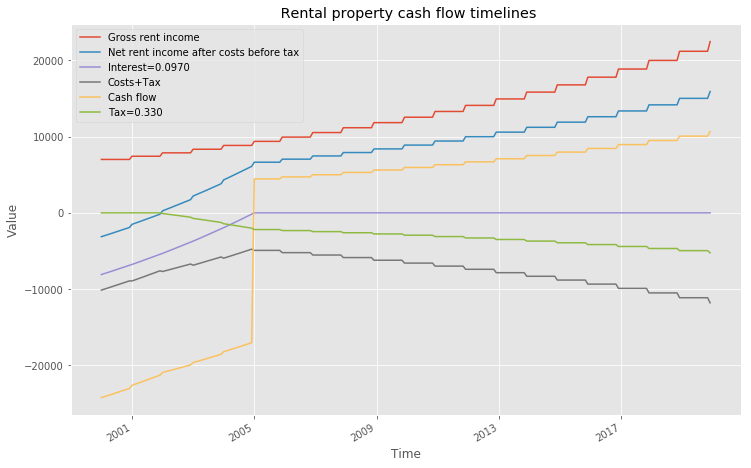

In [39]:
plotrentalpropcashflowtimeline(dfc)

Define the effective rent income as the fraction of the net rent income (after costs) to the gross rent income. With zero cost the effective rent income should be 1. Any costs will reduce this income to smaller than 1. We answer the question:  after costs, what is the net inflow from the investment?

In this graph, costs are defined as all outflows against the rental property, including bonded loan interest, agent's fees, levies, rates and taxes and maintenance.
This value does not include income tax in the hands of the investor or the down payment against the loan capital or principal. 

In the graph below the loan is repaid after five years and the interest is zero.

The graph title shows the mean value over the extended period of study. This value include the initial negative cash flow (interest), but excludes income tax and loan capital repayment.


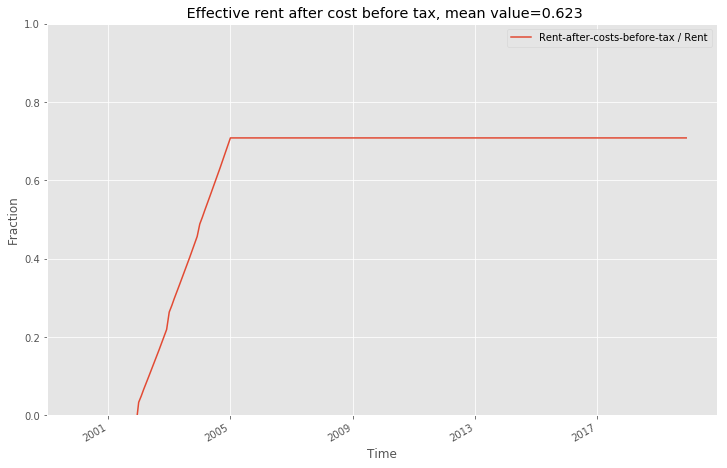

In [40]:
plotrentalpropeffectiverent(dfc)    

### Effect of income tax and  bonded loan duration 

Next investigate the effect of mortgage bond duration and tax rate on net cumulative cash flow over an extended period.
If you buy a property, which mortgage bond duration will give the best net cash flow over an extended period?   
How much does the cash flow differ for different bond  durations?  

The model considers the cumulative cash flow over a 20-year duration, of which the bond duration is the first $n$ years.  The principal amount, interest rate, the rent and all other costs are the same in all cases, only the bond payment duration varies.

In [41]:
principal = 1000000
interest_rate = 0.097
calcyears = 20
rentpmonth = 7000
rentpermonthInc = 0.06
agentPcnt = 0.08
maintPcnt = 0.03
riskPcnt = 0.01
levy = -600
ratesnt = -600
levyInc = 0.06
ratesntInc = 0.06

dfSum = pd.DataFrame()

for bondyears in [3, 4,5,7,10,20]:
    for taxrate in [0.2, 0.33, 0.42]:
        dfc,istats = rentalProperty(principal=principal,interest_rate=interest_rate,
                bondyears=bondyears,calcyears=calcyears,rentpmonth=rentpmonth,rentpermonthInc=rentpermonthInc,
                agentPcnt=agentPcnt,levy=levy,ratesnt=ratesnt,levyInc=levyInc,
                ratesntInc=ratesntInc,maintPcnt=maintPcnt,taxrate=taxrate,riskPcnt=riskPcnt,doplot=False)

        # append all summaries into single df
        dfSum = dfSum.append(istats,ignore_index=True)



The table below shows the scenario parameters for the results shown further down below:

In [42]:
istatsfiltex = istats[['Bond','Interest Rate','CalcYears','InitRent','RentIncrease','InitLevy',
                    'LevyIncrease','InitR&T','R&TIncrease','AgentPcnt','MaintPcnt','RiskPcnt']]
display(HTML(istatsfiltex.to_frame().to_html(index=True)))

,0
Bond,1000000
Interest Rate,0.097
CalcYears,20
InitRent,7000
RentIncrease,0.06
InitLevy,-600
LevyIncrease,0.06
InitR&T,-600
R&TIncrease,0.06
AgentPcnt,0.08


###  Net cumulative cash flow

The table shows the net cumulative cash flow (sum of cash flow over the extended period `CalcYears` od 20 years) as a function of bond pay-back period and tax rate.

It is clear that a 42% tax rate requires that the bond be paid off in three years in order to achieve a  positive net cumulative cash flow *only after 20 years*.
In this case the investment has only paid back the loan money but has not yet given any other income.

At a 20% tax rate the investment provides positive net cumulative cash flow after 20 years for a bond paid off in less than seven years.
At this tax rate, if you repaid the bond in four years, the investment will return about 400k net cash flow after 20 years.

At a 33% tax rate the investment provides positive net cumulative cash flow after 20 years for a bond paid off in less than four years.

Tax and *all* of the other 'cost' items contribute to this performance: the conclusion is that all costs must be minimised to make the investment worthwhile in terms of net cumulative cash flow after 20 years.


In [43]:
dft = pd.pivot_table(dfSum, index=['BondYears'],values=['CumCashFlow'],columns=['TaxRate'])
display(HTML(dft.to_html(index=True)))


### Effective rent after cost before tax

The following table shows the net rent income after costs (including interest) before income tax (also excluding the repayment of the loan capital).

It is evident for the property considered here, the longer term loan durations spends most of the rental income to repay the bond.

The data in the table is shown further down in graph format, when comparing with alternative investment options.

In [44]:
dfer = pd.pivot_table(dfSum, index=['BondYears'],values=['RentAfterCostsB4TaxFrac'],columns=['TaxRate'])
display(HTML(dfer.to_html(index=True)))

### Alternative, lower cost investment analysis

Consider less expensive property with lower rental income, but where the rent is relatively higher compared to the price of the property.

Consider a property at a quarter of the purchase cost of the property considered above, but where the property raises 3000 rental income.
In order to keep the same loan amount, four properties are bought and considered as a collective in this analysis.

The risk of damages in cheaper properties is higher than for the more expensive investment.  
How much higher must the risk be for similar returns as on the expensive property?
We consider a reasonable risk value 10% of rent, and the threshold value (26% for these scenarios) where the more expensive property is the better investment.


In [45]:
principal = 4 * 250000
interest_rate = 0.097
calcyears = 20
rentpmonth = 4 * 3000
rentpermonthInc = 0.06
agentPcnt = 0.08
maintPcnt = 0.03
riskPcnts = [0.1, 0.26]
levy = -4 * 400
ratesnt = -4 * 250
levyInc = 0.06
ratesntInc = 0.06

dfSum2 = pd.DataFrame()

for riskPcnt in riskPcnts:
    for bondyears in [3, 4,5,7,10,20]:
        for taxrate in [0.2, 0.33, 0.42]:
            dfc,istats = rentalProperty(principal=principal,interest_rate=interest_rate,
                    bondyears=bondyears,calcyears=calcyears,rentpmonth=rentpmonth,rentpermonthInc=rentpermonthInc,
                    agentPcnt=agentPcnt,levy=levy,ratesnt=ratesnt,levyInc=levyInc,
                    ratesntInc=ratesntInc,maintPcnt=maintPcnt,taxrate=taxrate,riskPcnt=riskPcnt,doplot=False)

            # append all summaries into single df
            dfSum2 = dfSum2.append(istats,ignore_index=True)


In [46]:
istatsfilt = istats[['Bond','Interest Rate','CalcYears','InitRent','RentIncrease','InitLevy',
                    'LevyIncrease','InitR&T','R&TIncrease','AgentPcnt','MaintPcnt']]
display(HTML(istatsfilt.to_frame().to_html(index=True)))

,0
Bond,1000000
Interest Rate,0.097
CalcYears,20
InitRent,12000
RentIncrease,0.06
InitLevy,-1600
LevyIncrease,0.06
InitR&T,-1000
R&TIncrease,0.06
AgentPcnt,0.08


In [47]:
dftc = {}
for i,riskPcnt in enumerate(riskPcnts):
    dftc[i] = pd.pivot_table(dfSum2.loc[dfSum2['RiskPcnt']==riskPcnts[i]], 
                             index=['BondYears'],values=['CumCashFlow'],columns=['TaxRate'])
#     display(HTML(dftc[i].to_html(index=True)))


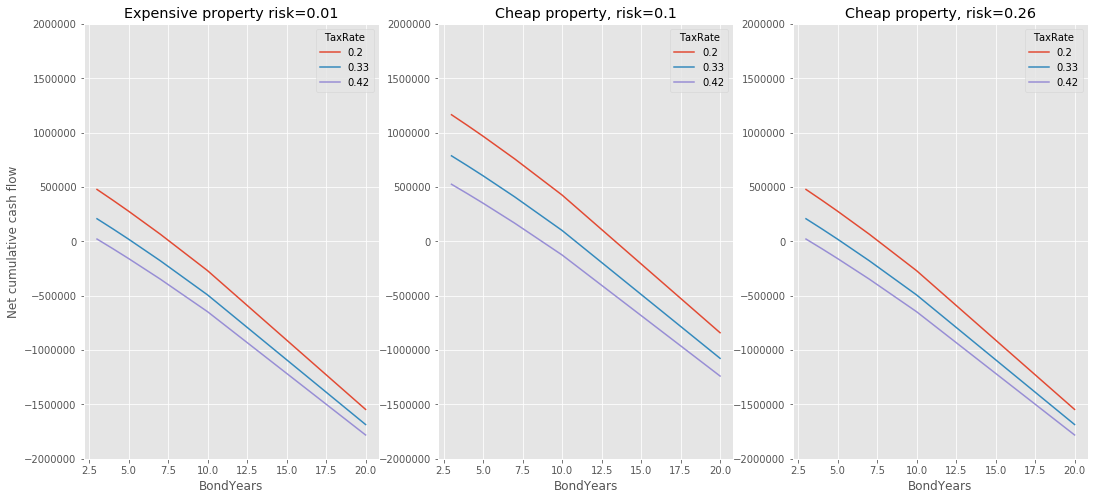

In [48]:
import matplotlib.pyplot as plt
figsize(18,8)
fig, axes = plt.subplots(nrows=1, ncols=3)
dft.reset_index().plot(x='BondYears',y='CumCashFlow',  ax=axes[0],ylim=[-2e6,2e6])    
axes[0].set_ylabel("Net cumulative cash flow");
axes[0].set_title(f"Expensive property risk={istatsfiltex['RiskPcnt']}");

for i,riskPcnt in enumerate(riskPcnts):
    dftc[i].reset_index().plot(x='BondYears',y='CumCashFlow',  ax=axes[i+1],ylim=[-2e6,2e6])      
    axes[i+1].set_title(f"Cheap property, risk={riskPcnt}");

The above analysis shows that for the scenarios considered, if the risk is higher than 26% of rent, the more expensive property is the better investment.
This is however, quite a high risk, it should be lower in a well managed portfolio.

The graphs show that at 10% risk, the less expensive property performs somewhat more than twice as good as the more expensive property.

In conclusion, if you are able and willing to manage the risks down low, the less expensive properties are considerable better investments than the more expensive property.
If the risks are higher or you don't want the trouble of managing risk and trouble the more expensive property still remains an option (less attractive though), especially if you do not operate the properties as a large scale business.

Finally, it seems that unless you tightly manage the costs and risks the cost of a rental investment, in terms of rental income only (ignoring capital growth) is of the same order as the costs of managed investments such as unit trusts (managed investments). If the management fee of a  unit trust is around 2% of fund value, the investor loses about 40% of the potential growth of the investment (details to follow).


Keep in mind that capital growth is not yet factored into this analysis.

## Moving funds between bonds 

### The scenario

Suppose I need to raise some money to buy a third property but a mortgage bond is not desired because the money must be paid back in a short time.  It was shown above that for shorter-term loans, the statutory and legal costs of obtaining the bond minimise the tax savings benefit on interest.

There are two existing mortgage bonds against which money can be drawn against (known as Access Bonds). The funds available for withdrawal in the access bond is equal to the *additional* money previously deposited (using the loan account as a 'savings' account).
The two properties under bond raise rent income, hence the interest can be claimed against tax.  The final objective is to repay the mortgage bonds in four years. How much money must be drawn from the different mortgage bonds to raise the new money for the lowest total cost? To repay all three bonds in the required time, how much additional payment must be made in each mortgage bond?

This is a classical minimisation problem, which can be solved by many different techniques.  The present calculation manually allocated the required 'new' funds to the two existing bonds up to the limit these bonds can supply.

The parameters for the three properties are shown in the dictionary below.  The principal amount for property PropertyV is made equal to 0 in order to make the functions work, but essentially is zero, hence also with zero interest costs.

In [49]:

sources = {
'PropertyK':{'principal':950000, 'interest_rate':0.0915,'rentpmonth':11395,'agentPcnt':0.12,'levy':0,'ratesnt':837,} ,   
'PropertyB':{'principal':610000, 'interest_rate':0.097,'rentpmonth':6500,'agentPcnt':0.09,'levy':983,'ratesnt':653,} ,   
'PropertyV':{'principal':1, 'interest_rate':0.001,'rentpmonth':7000,'agentPcnt':0.09,'levy':585,'ratesnt':650,}    
}

bondyears = 4
calcyears = 4
rentpermonthInc = 0.06
maintPcnt = 0.03
riskPcnts = 0.02
levyInc = 0.06
ratesntInc = 0.06
taxs = [0.2, 0.33, 0.42]
taxselect = 1

dfSum = pd.DataFrame()
df = pd.DataFrame()

for i,key in enumerate(sources.keys()):
    s = sources[key]
    for taxrate in taxs:
        dfc,istats = rentalProperty(principal=s['principal'],interest_rate=s['interest_rate'],
                bondyears=bondyears,calcyears=calcyears,rentpmonth=s['rentpmonth'],rentpermonthInc=rentpermonthInc,
                agentPcnt=s['agentPcnt'],levy=s['levy'],ratesnt=s['ratesnt'],levyInc=levyInc,
                ratesntInc=ratesntInc,maintPcnt=maintPcnt,taxrate=taxrate,riskPcnt=riskPcnt,doplot=False,
                ID=key)
        
        df = df.append(dfc,sort=True)
        dfSum = dfSum.append(istats,ignore_index=True)

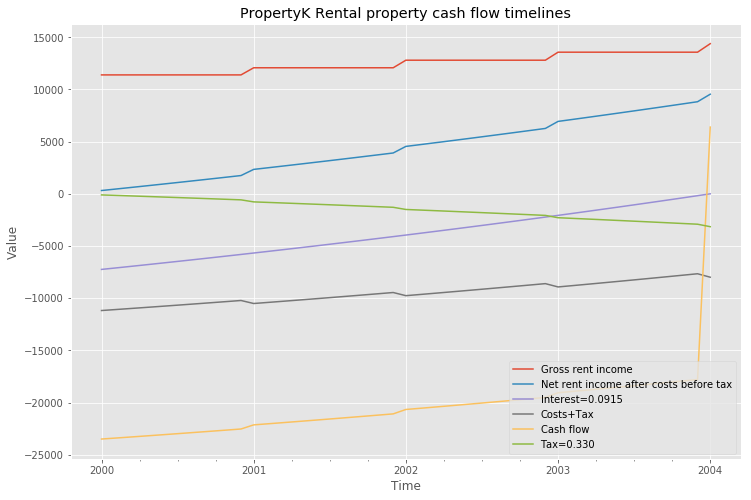

In [50]:
dfs = df.loc[(df['Principal'] == sources['PropertyK']['principal']) & (df['TaxRate'] == taxs[taxselect])]
plotrentalpropcashflowtimeline(dfs)

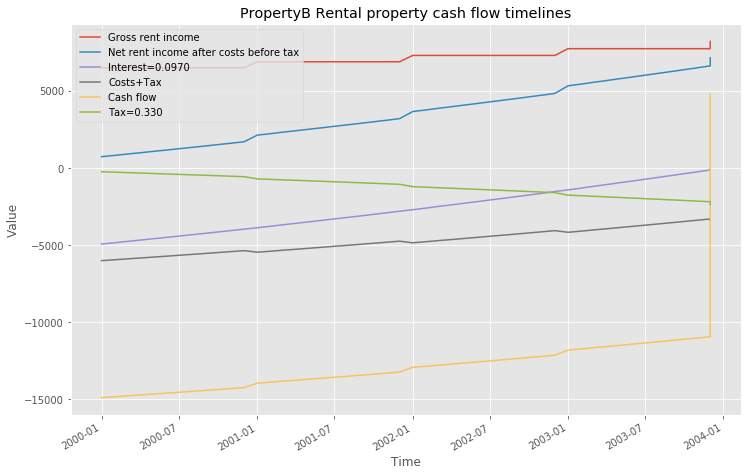

In [51]:
dfs = df.loc[(df['Principal'] == sources['PropertyB']['principal']) & (df['TaxRate'] == taxs[taxselect])]
plotrentalpropcashflowtimeline(dfs)

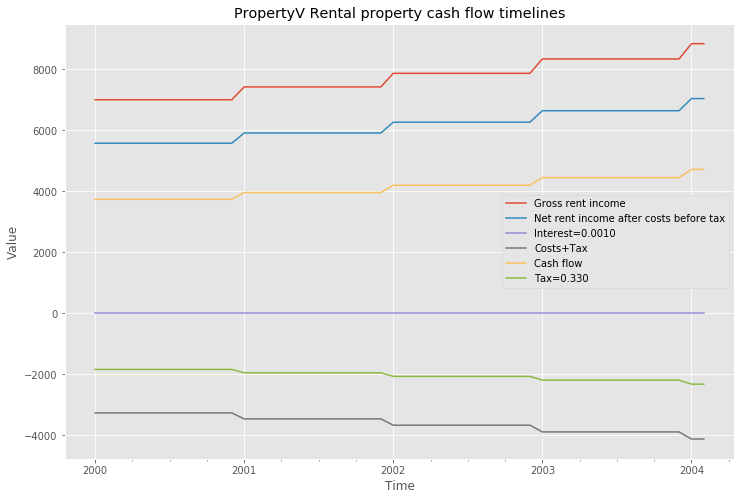

In [52]:
dfs = df.loc[(df['Principal'] == sources['PropertyV']['principal']) & (df['TaxRate'] == taxs[taxselect])]
plotrentalpropcashflowtimeline(dfs)

,Month,CashFlow
0,2000-01-01,-34652.2351
1,2000-02-01,-34511.5150
2,2000-03-01,-34369.6961
3,2000-04-01,-34226.7583
4,2000-05-01,-34082.7150


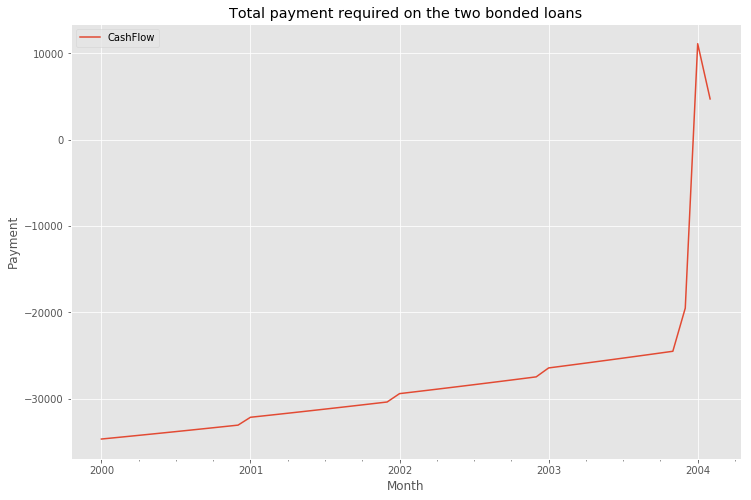

In [53]:

#calculate the sum of all cash flow values available for each month
# do this for one value of tax rate
dfsum = pd.pivot_table(df.loc[df['TaxRate'] == taxs[taxselect]], 
                             index=['Month'],values=['CashFlow'],aggfunc=np.sum)
dfsum.reset_index(level=0, inplace=True)

display(HTML(dfsum.head().to_html(index=True)))

figsize(12,8)
fig, axes = plt.subplots(nrows=1, ncols=1)
dfsum.plot(x='Month',y='CashFlow',  ax=axes)    
axes.set_ylabel("Payment");
axes.set_title("Total payment required on the two bonded loans");

## Investment Growth

In [54]:
def investmentgrowth(initialvalue, growthrate, termyears, addpayment=0, addpaymentrate=0, 
                     costBalPcnt=0, start_date=(date(2000,1,1)), cyclesPerAnnum=12,ID=''):
    """
    Calculate the amortization schedule given the loan details.

    :param initialvalue: Initial value paid into the investment
    :param growthrate: The annual growth rate for this investment
    :param termyears: Number of years for the investment
    :param addpayment: Additional investment amount per period
    :param addpaymentrate: growth in the additional investment compounded annually 
    :param costBalPcnt: managment cost as percentage on balance
    :param start_date: Start date for the loan.
    :param cyclesPerAnnum: Number of investment payment cycles in a year.
    :param ID: String ID for this calculation.

    :return: 
        schedule: investment schedule as an Ordered Dictionary
    """

    # initialize the variables to keep track of the periods and running balances
    p = 1
    beg_balance = initialvalue
    end_balance = initialvalue
    currentyear = start_date.year

    while p < termyears * cyclesPerAnnum:
        
        # Recalculate the growth based on the current balance
        growth = - beg_balance * growthrate / cyclesPerAnnum
        
        # cost on balance
        costBal = beg_balance * costBalPcnt / cyclesPerAnnum
        
        # total costs
        costs = costBal
        
        end_balance = beg_balance - growth + addpayment - costs

        yield OrderedDict([('Month',start_date),
                           ('Period', p),
                           ('Begin Balance', beg_balance),
                           ('InitialVal', initialvalue),
                           ('GrowthRate', growthrate),
                           ('Growth', growth),
                           ('AddPayment', addpayment),
                           ('AddPayRate', addpaymentrate),
                           ('CostBalance',costBal),
                           ('End Balance', end_balance),
                           ('ID', ID),
                          ])
        
        # Increment the counter, balance and date
        p += 1
        if cyclesPerAnnum == 12:
            start_date += relativedelta(months=1)
        elif  cyclesPerAnnum == 365.25:
            start_date += relativedelta(days=1)
        else:
            print(f'Unknown cyclesPerAnnum = {cyclesPerAnnum}')
            return None
        beg_balance = end_balance
        
        # only increase the additional payment once per year
        if start_date.year != currentyear:
            currentyear = start_date.year
            addpayment *= 1 + addpaymentrate

In [55]:
def investment_table(initialvalue, growthrate, termyears, addpayment=0, addpaymentrate=0, costBalPcnt=0,
                     start_date=(date(2000,1,1)), cyclesPerAnnum=12,ID=''):
    """
    Calculate the amortization schedule given the loan details as well as summary stats for the loan

    :param initialvalue: Initial value paid into the investment
    :param growthrate: The annual growth rate for this investment
    :param termyears: Number of years for the investment
    :param addpayment: Additional investment amount per period
    :param addpaymentrate: growth in the additional investment compounded annually 
    :param costBalPcnt: managment cost as percentage on balance
    :param start_date: Start date for the loan.
    :param cyclesPerAnnum: Number of investment payments in a year.
    :param ID: String ID for this calculation.

    :return: 
        schedule: investment schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the investment
    """
    
    # Generate the schedule 
    schedule = pd.DataFrame(investmentgrowth(initialvalue=initialvalue, growthrate=growthrate, 
                                termyears=termyears,addpayment=addpayment, addpaymentrate=addpaymentrate, 
                                             costBalPcnt=costBalPcnt,start_date=start_date, 
                                             cyclesPerAnnum=cyclesPerAnnum,ID=ID))
    
    # reorder the columns
    schedule = schedule[['Period','Month','Begin Balance','InitialVal','GrowthRate','Growth',
                         'AddPayment','AddPayRate','End Balance','ID']]

    # Convert to a pandas datetime object to make subsequent calcs easier
    schedule["Month"] = pd.to_datetime(schedule["Month"])
    
    #Create a summary statistics table
    endBalance = schedule.iloc[-1]["End Balance"]
    stats = pd.Series([ID,initialvalue,growthrate,
                       termyears,addpayment,addpaymentrate,
                       endBalance,costBalPcnt],
                       index=['ID','InitialVal','GrowthRate',
                              'Years','AddPayment','AddPayRate',
                              'EndBalance','CostBalPcnt'])
    
    return schedule, stats

### The True Cost of Commission on Value of Investments

From 
https://www.coronation.com/personal/new-investor/about-unit-trusts/:
A unit trust (also known as a ‘fund’) pools money from many investors to invest in assets like shares, bonds and property. Instead of having to pick individual investments yourself, a unit trust offers you exposure to a range of assets, which are selected and managed by investment professionals. Each fund is divided into equal units. The price of each of these units is based on the value of all the investments in the fund. As an investor, you own a number of units in a fund. Over time, the price of these units will track the value of the underlying investments. 
Coronation does not charge any initial or upfront fees to invest in our unit trust funds. Your full investment amount is invested to purchase units. Our unit trusts charge an annual management fee which is calculated daily. Certain funds may charge a performance fee which is accrued daily and paid monthly for all funds, except the Coronation Optimum Growth fund which is paid annually on 30 September. For more information, please view our Fee Schedule in the forms section on Coronation.co.za. 
The Coronation schedule lists fees of 0.85% to 1.25%, and in some funds even 3% (Domestic long term Top 20). Other fund managers have similar fees.

The fund manager takes this fee on a daily basis (compounded) irrespective of the performance of the investment. The investment grows slower because of the investment commission. If the investment is not growing positively, the investment loses money at these daily compounded rates. 

Consider the effect of a percentage cost on the value of an investment to the long term value.
The scenarios considered here are for an initial investment followed by either no further investment or a fixed monthly investment.
Different values for management commission are considered where zero commission is the baseline for best possible growth.

In [56]:
initialvalue = 1000
growthrate = 0.06
termyears = 30
addpayments = [0,100]
addpaymentrate = 0.
costBalPcnts = [0.0, 0.01, 0.015, 0.02, 0.03]
cyclesPerAnnum = 12

dfSum = pd.DataFrame()

for addpayment in addpayments:
    for costBalPcnt in costBalPcnts:
        schedule, stats = investment_table(initialvalue, growthrate, termyears, addpayment=addpayment, 
                                   addpaymentrate=addpaymentrate,costBalPcnt=costBalPcnt,ID='',
                                  cyclesPerAnnum=cyclesPerAnnum)
        
        # append all summaries into single df
        dfSum = dfSum.append(stats,ignore_index=True)


In [57]:
pd.pivot_table(dfSum, index=['CostBalPcnt'],values=['EndBalance'],columns=['AddPayment'])

EndBalance              
AddPayment        0.0           100.0
CostBalPcnt                          
0.000        5992.61215  105844.85518
0.010        4449.20596   87230.14890
0.015        3833.32309   79388.60545
0.020        3302.48972   72377.18118
0.030        2450.71542   60479.33234

Normalise the fund value by the scenario where there is zero costs. When the investment is measured against this baseline, the true cost of the commission becomes apparent.

In [58]:
# calculate a normalised end balance for the different scenarios
dfSum['EndBalanceN'] = np.nan
AddPaymentU = dfSum['AddPayment'].unique()
for addpayment in addpayments:
    normval = dfSum.loc[(dfSum['CostBalPcnt'] == 0) & (dfSum['AddPayment'] == addpayment)]['EndBalance'].values[0]
    dfSum.loc[dfSum['AddPayment'] == addpayment,'EndBalanceN'] = (dfSum.loc[dfSum['AddPayment'] == addpayment,'EndBalance'])/normval


In [59]:
pd.pivot_table(dfSum, index=['CostBalPcnt'],values=['EndBalanceN'],columns=['AddPayment'])

EndBalanceN         
AddPayment        0.0      100.0
CostBalPcnt                     
0.000           1.00000  1.00000
0.010           0.74245  0.82413
0.015           0.63967  0.75005
0.020           0.55109  0.68380
0.030           0.40896  0.57140

The table says the following:
    
1. If a lump sum only is invested with no future payments:
    1. a commission of 1% consumes 25% of the total investment value.
    1. a commission of 2% consumes 45% of the total investment value.
    1. a commission of 3% consumes 60% of the total investment value.


1. If a lump sum only is invested followed up with monthly future payments:
    1. a commission of 1% consumes 18% of the total investment value.
    1. a commission of 2% consumes 32% of the total investment value.
    1. a commission of 3% consumes 43% of the total investment value.


----------------------------------------------

## Retirement Fund Depletion

A key question when it comes to retirement, is 'how long will the money last?'
The answer to this question depends on very many factors including predictable and unpredictable factors
Unpredictable factors include new investment opportunities and risks such as ill health, market crashes and crime. The answer also depends somewhat on (uncontrollable) factors that can be estimated or at least modelled by making reasonable assumptions.  These factors include investment growth and inflation, which we can use in models to predict outcomes, given the occurrence of these factors.  These assumptions can be long term averages (assuming stationary conditions) or can be variable on the time line, our modelling must just be able to handle these assumptions.

### Four Percent Rule

Fund managers currently advise that you do not with draw more than 4% to 5% per year of your total investment portfolio, in order to outlive your retirement funds. This is known as the [four percent rule](https://www.investopedia.com/terms/f/four-percent-rule.asp). This means that if you saved 1000k, the annual withdrawal should not be more than 40k to 50k. Put differently, you need a portfolio of 25 to 20 times your required annual pension. If you want to retire with 1m per year, you need a portfolio of 25m.
The purpose with this analysis is to confirm this advice and to determine the assumptions made in this general advice.

The [four percent rule](https://www.investopedia.com/terms/f/four-percent-rule.asp) aims to ensure that you do not run out of money during requirement.  The idea is that investment growth will normally be sufficient to cover a four percent withdrawal from the investments per annum.  This rule is based on 50-year data prior to the mid 1970's in the US

This rule is not always valid for all people.  As people grow older or require more medical care the the four percent withdrawal may not sustain until death. If the person has high risk investments too high a withdrawal rate (even four percent) may pose a risk in later years.  Occasional high spending may also erode the investment to prevent long term returns.

The analysis below provides some insight into the role of percentage withdrawals on the sustainability of long term retirement.

### Time value of money

Inflation and investment have the effect of predicting very large numbers in the longer term.  These large numbers are difficult to interpret from the present; we loose the 'feel' of what money really is worth.

Suppose it is possible to freeze the time value of money, to always retain a constant buying power.  With the time value of money frozen, we can evaluate the value of asset growth and costs in a manner decoupled from the erosion effect of inflation: we evaluate the investment or cost in terms of  true buying power.  The money value would always have constant buying power irrespective of time into the future.

The underlying principle used here is similar to the financial tool called Discounted Cash Flow (DCF) except that the target calculation here is to determine the time when the investment will be depleted given constant monthly withdrawal that probably exceeds the monthly growth, eating away into the investment capital.

Freezing the time value of money is readily done by considering any costs or growth relative to the inflation rate. Simply subtract the inflation rate from investment growth and from cost growth.  
If the inflation rate is 6% and an investment realises 8% growth after tax and costs, the real growth (corrected for inflation) is 2%. If medical inflation rises by 9% in a 6% inflation economy, it means that in real terms the medical costs increases by 3% per year.  Hence the effect of inflation on time value of money can be removed by considering all costs and growth relative to inflation: just subtract inflation rate.

### Retirement fund depletion: simple model, assuming stationary markets

In the (simple) initial study shown below, long term average values are used (constant over the full term duration).  This is quite limiting in that long average are not good predictors, but at least it gives us an idea of what could happen under stationary conditions.  However, there is sufficient evidence that investment returns are not stationary, not even in the longer term. For this purpose a more representative model using actual market movements and Monte Carlo simulations will be developed later.

Of course, this a a very simple model, assuming stationary conditions (other than inflation).
A more advanced model can have time varying inflation, cost, and investment growth, but the underlying principle would still remain: subtract the inflation rate from the cost and investment growth rates.

#### Simple model calculation approach

Many years ago I modelled a very simple retirement fund depletion model in an Excel [spreadsheet](https://github.com/NelisW/RetirementPlanning/blob/master/Retirement%20Planning.xls) and now will expand on that model in Python/Pandas. The model is as follows:

1. Start with an initial investment value, a single number of the investment portfolio total value.

1. Iterate on a monthly interval and repeat the following calculation:

    1. Withdraw money from the portfolio (pension to live from, medical costs, etc.). 

    1. Allow the withdrawal amount to rise in the next month by a percentage equal to the actual rise percentage minus the inflation percentage. In other words, allow the withdrawal to rise in real terms, corrected for inflation.  We allow this growth to assure that medical inflation will be covered (medical inflation is generally higher than cost of living inflation).

    1. Add a portfolio investment growth amount as expected % growth minus % inflation for the month. In other words add the real growth, corrected for inflation.

1. Repeat month by month, until the money runs out.

This model is really simple with several failings:

1. Inflation and investment growth are not stationary and often vary in contrary motion.

2. Different investment classes perform differently, with different risks and different cycles. To simplify growth in into a single number is a gross simplification of the real situation.





The calculation procedure are similar to the amoritisation, using a generator function to iterate until the investment is depleted or `maxyears` are reached.

In [60]:
def investmovement(initialsum, growthrate, withdrawal, withdrawalrate, 
                    start_date=(date(2000,1,1)), cyclesPerAnnum=12,ID='',maxyears=55):
    """
    Calculate the retirement investment schedule given the growth and withdrawal rates.

    All rates are real rates, corrected for inflation

    :param  initialsum:  total portfolio must be positive
    :param  growthrate:  rate at which investment grows
    :param  withdrawal:  monthly withdrawal at start of retirement
    :param  withdrawalrate:  annual rate of increase in withdrawal
    :param  start_date:  retirement date
    :param  cyclesPerAnnum: normally 12 months per year
    :param  ID: identification for this calculation
    :param  maxyears: terminate the run after so many years

    :return: 
        schedule: retirement investment schedule as an Ordered Dictionary
    """

    # initialize the variables to keep track of the periods and running balances
    p = 1
    beg_balance = initialsum
    end_balance = initialsum
    currentyear = start_date.year

    while end_balance < 0 and p <maxyears * cyclesPerAnnum + 2:
        
        # withdraw money at the beginning of month
        if beg_balance > withdrawal:
            withdrawal = beg_balance
            
        beg_balance = beg_balance - withdrawal 

        # Recalculate the growth based on the current balance
        growth =  (growthrate/cyclesPerAnnum) * beg_balance
        end_balance = beg_balance + growth
        
        if np.abs(end_balance) < 1:
            end_balance = 0

        yield OrderedDict([('Month',start_date),
                           ('Period', p),
                           ('BeginBalance', beg_balance),
                           ('EndBalance', end_balance),
                           ('Initialsum', initialsum),
                           ('Growth', growth),
                           ('GrowthRate', growthrate),
                           ('WithdrawalRate', withdrawalrate),
                           ('Withdrawal', withdrawal),
                           ('ID', ID),
                          ])
        

        # Increment the counter, balance and date
        p += 1
        
        if cyclesPerAnnum == 12:
            start_date += relativedelta(months=1)
        elif  cyclesPerAnnum == 365.25:
            start_date += relativedelta(days=1)
        else:
            print(f'Unknown cyclesPerAnnum = {cyclesPerAnnum}')
            return None

        beg_balance = end_balance
        
        # only increase the withdrawal payment once per year
        if start_date.year != currentyear:
            currentyear = start_date.year
            withdrawal *= 1 + withdrawalrate


def investmovement_table(scenario,initialsum, growthrate, withdrawal, withdrawalrate, retire_age=65,
                    start_date=(date(2000,1,1)), cyclesPerAnnum=12,ID='',maxyears=55):
    """
    Calculate the retirement investment schedule given the investment and withdrawal details

    :param  scenario:  string identifier
    :param  initialsum:  total portfolio must be positive
    :param  growthrate:  rate at which investment grows
    :param  withdrawal:  monthly withdrawal at start of retirement
    :param  withdrawalrate:  annual rate of increase in withdrawal
    :param  retire_age:  age at the start of fund depletion
    :param  start_date:  retirement date
    :param  cyclesPerAnnum: normally 12 months per year
    :param  ID: identification for this calculation
    :param  maxyears: terminate the run after so many years

    :return: 
        schedule: investment schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the payoff information
    """
    
    # Generate the schedule 
    schedule = pd.DataFrame(investmovement(initialsum, growthrate, withdrawal, withdrawalrate,
                                           start_date=start_date,ID=ID,maxyears=maxyears))
    if schedule.empty:
        stats = pd.Series([scenario,0,0,initialsum,0,growthrate,withdrawalrate,withdrawal,ID],
                   index=['Scenario','Duration','Age@End','Initialsum','EndBalance','GrowthRate','WithdrawalRate','Withdrawal','ID'])
        return None, stats

    # reorder the columns
    # schedule = schedule[['Month','Period','BeginBalance','Initialsum','GrowthRate','WithdrawalRate','Withdrawal','ID']]
    
    # Convert to a pandas datetime object to make subsequent calcs easier
    schedule["Month"] = pd.to_datetime(schedule["Month"])
    
    endbalance = schedule["EndBalance"].iloc[-1]
    final_date = schedule["Month"].iloc[-1]
    final_withdraw = min(schedule["Withdrawal"].iloc[-1],schedule["Withdrawal"].iloc[-2])
    duration = ((final_date - pd.to_datetime(start_date))/(12 * np.timedelta64(1, 'M')))
    age_end = retire_age + duration
    #Create a summary statistics table
    stats = pd.Series([scenario,duration,age_end,initialsum,endbalance,growthrate,withdrawalrate,withdrawal,final_withdraw,ID],
                       index=['Scenario','Duration','Age@End','Initialsum','EndBalance','GrowthRate','WithdrawalRate','Withdrawal','WithdrawalFinal','ID'])
    
    return schedule, stats

if False:
    initialsum = -1000000
    growthrate = +.01
    withdrawalrate = +.01
    withdrawal = -3333
    retire_age=65
    scenario = 'Test'
    maxyears = 30
    df, stats = investmovement_table(scenario=scenario,initialsum=initialsum, growthrate=growthrate,
                 withdrawal=withdrawal, withdrawalrate=withdrawalrate,retire_age=retire_age,ID='',maxyears=maxyears)

    print(df.head(20))
    print(df.tail(20))
    print(stats)

Evaluate a number of scenarios with different investment growth rate and withdrawal growth rate.  Remember that these rates are relative to inflation. The withdrawal growth rate could well be above cost of living inflation, because of medical inflation that increases at old age.  Some advisors estimate medical inflation to be as high as 3% to 5% above inflation.  The present calculation does not provide for medical expense as a separate cost item, it must be factored into the withdrawal growth.

The set of scenarios evaluated next are the same as in my previous spreadsheet, serving as a reference against the previous baseline.

In [61]:
def stationaryretirementdepletion(initialsum,retire_age,scenarios,annualwithdrawals,maxyears=55):

    dfa = pd.DataFrame()
    dfSum = pd.DataFrame()

    for annualwithdrawal in  annualwithdrawals:
        withdrawal = initialsum * annualwithdrawal / 12

        for scenario in scenarios:
            growthrate = scenarios[scenario]['growthrate']
            withdrawalrate = scenarios[scenario]['withdrawalrate']

            df, stats = investmovement_table(scenario=scenario,initialsum=initialsum, growthrate=growthrate,
                     withdrawal=withdrawal, withdrawalrate=withdrawalrate,retire_age=retire_age,ID='',maxyears=maxyears)

            dfa = dfa.append(df)

           # append all summaries into single df
            dfSum = dfSum.append(stats,ignore_index=True)

    dfSum['Ratio'] = dfSum['Initialsum']/(12 * dfSum['Withdrawal'])
    dfSum['Withdrawal0'] = 1 / dfSum['Ratio']
    
    newbalancename = f'End balance as percentage of initial after {maxyears} years'
    dfSum[newbalancename] = dfSum['EndBalance']
    
    newagename = f'Age at funds depleted or {maxyears} years, retirement at {retire_age}'
    dfSum[newagename] = dfSum['Age@End']
    
    newdurationname = f'Duration till funds depletion or {maxyears} years'
    dfSum[newdurationname] = dfSum['Duration']
    
    withdrawalfinalname = f'Withdrawal in final year of funds depletion or {maxyears} years as a percentage of initial investment'
    dfSum[withdrawalfinalname] = dfSum['WithdrawalFinal'] * 12 / initialsum
    
    dfAgeEnd = pd.pivot_table(dfSum, index=['Withdrawal0','Ratio'],values=[newagename],columns=['Scenario'])
    dfDuration = pd.pivot_table(dfSum, index=['Withdrawal0','Ratio'],values=[newdurationname],columns=['Scenario'])
    dfMoneyLeft = pd.pivot_table(dfSum, index=['Withdrawal0','Ratio'],values=[newbalancename],columns=['Scenario']) * 100 /  initialsum  
    dfFinWithDr = pd.pivot_table(dfSum, index=['Withdrawal0','Ratio'],values=[withdrawalfinalname],columns=['Scenario'])  

    return dfSum,dfAgeEnd,dfDuration,dfMoneyLeft,dfFinWithDr,newbalancename,newagename,newdurationname,withdrawalfinalname

In [62]:
initialsum = -1000000
retire_age = 65
maxyears = 30

scenarios = {
    'g-0.02, w0.00':{'growthrate':-0.02, 'withdrawalrate':0.00},
    'g-0.02, w0.01':{'growthrate':-0.02, 'withdrawalrate':0.01},
    'g0.00, w0.00':{'growthrate':0.00, 'withdrawalrate':0.00},
    'g0.00, w0.01':{'growthrate':0.00, 'withdrawalrate':0.01},
    'g0.00, w0.02':{'growthrate':0.00, 'withdrawalrate':0.02},
    'g0.00, w0.04':{'growthrate':0.00, 'withdrawalrate':0.04},
    'g0.02, w0.00':{'growthrate':0.02, 'withdrawalrate':0.00},
    'g0.02, w0.01':{'growthrate':0.02, 'withdrawalrate':0.01},
    'g0.02, w0.02':{'growthrate':0.02, 'withdrawalrate':0.02},
#     'g0.04, w0.0':{'growthrate':0.04, 'withdrawalrate':0.00},
#     'g0.10, w0.0':{'growthrate':0.10, 'withdrawalrate':0.00},
#     'g0.04, w0.04':{'growthrate':0.04, 'withdrawalrate':0.04},
}

annualwithdrawals = [0.025, 0.03, 0.04,0.045,0.05,0.06,0.07,0.09,0.12,0.175]

dfSum,dfAgeEnd,dfDuration,dfMoneyLeft,dfFinWithDr,newbalancename,newagename,newdurationname,withdrawalfinalname\
        = stationaryretirementdepletion(initialsum,retire_age,scenarios,annualwithdrawals,maxyears=maxyears)

In the tables shown below each row represents a different initial withdrawal percentage (i.e., the 'four percent rule') expressed as a percentage of total investment and also as the ratio of investment sum to initial withdrawal.

Retiring at age 65, the money will run out at the ages shown in the table below.
If you want to retire at age 65, with life expectancy in the table, you need Ratio times the initial annual pension at 65.
So, retiring at age 65, with a pension of 1m/year, if you have 25m, it will last until age 85-90, depending on growth and withdrawals.
How long the money will last depends on the relative growth of investments vs increasing costs such as medical and other age-related expenses.
Medical costs typically grow 3-4% above inflation. However, assuming that some other costs grow less, we can work with a somewhat smaller average cost growth. So your investments must beat medical by at least, say, 2%.

The following are not included in the calculation:

1. Taxes on investment and personal income tax are not accounted for in these calculations.

1. Costs on investments such as broker fees, agent fees and fund manager fees.

1. Variations in market growth and inflation, for this calculation these are assumed constant.  It is assumed that market growth and withdrawal growth follows/tracks inflation and that they all move up or down together. This is not the case, because when inflation and investment growth tends to move antithetical.

Explanation of the tables below:

1. The rows downward shows the initial annual withdrawal (Withdrawal0) in the first year (start of pension) as percentage of total investment amount. This annual withdrawal amount expressed as an amount will then increase at the percentage rate 'w' shown in the various columns.  In other words the pension withdrawal is allowed to grow at some rate relative to inflation.  The value in the Ratio column is the ratio of total investment to the first year's (start of pension) annual withdrawal.

1. In the table headings below there are two numbers 'g0.00. w0.00' the 'g' number is annual percentage investment growth (after cost) above inflation and the 'w' number is the annual percentage withdrawal growth above inflation (to account for medical inflation). 

1. The *first row* is the 'Four percent rule' which means that in the first year of pension 4% or 1/25 of the total investment is withdrawn.  It is clear that if there is zero growth above inflation, and the withdrawal is kept constant at the same percentage (above inflation), the investment should last until the age of 90 (about 25 years).  On the other hand, with a 4% growth above inflation and constant withdrawal rate, the money should last more than 55 years (the simulation terminates at 55 years).


1. The *first column* `g0.00, w0.00` represents the scenario with zero annual growth (above inflation) and zero annual withdrawal increase (above inflation). The column shows that as the initial withdrawal increases from the minimum 2.5% to the maximum 17.5% allowed in South Africa, the pension duration shrinks from thirty years to just five and half years!


In [63]:
display(HTML(dfAgeEnd.to_html()))

The graph below shows the same information (the age where the funds are depleted) versus the (ratio of assets at retirement to annual income during retirement).

These graphs apply to a retirement age of 65 years.  It is much worse for forced retirement at an earlier age.
The various lines show growth in medical expenses and in the remaining assets, in real terms (i.e. relative to inflation).
Life expectancy for professional people with a healthy lifestyle currently is 92 years --- almost 30 years after retirement.
For the above life expectancy one requires total assets between 20 and 25 times your annual withdrawal at retirement.

For example, to survive till the age 92, with 1% growth in medical expense, and 2% net growth in invested assets, 
and to support an equivalent annual withdrawal of 100 000 at retirement, you require 25 times or 2,5m in assets.

For a ratio of 22, it is evident that your funds will be depleted 5 years later, if the real growth is 2% instead of 0% (for medical of 1%).

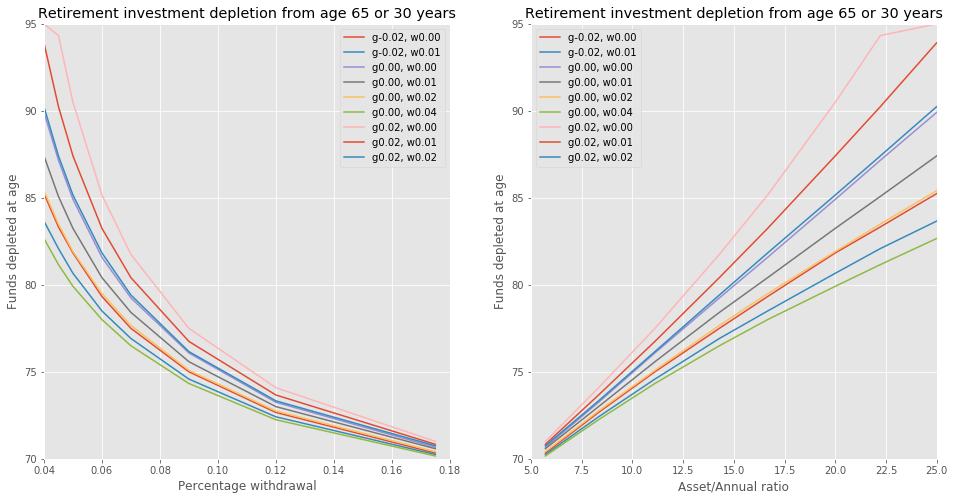

In [64]:
 
figsize(16,8)
fig, axes = plt.subplots(nrows=1, ncols=2)
for scenario in scenarios:
    dfSum[dfSum['Scenario']==scenario].plot(x='Withdrawal0',y='Age@End', label=scenario, ax=axes[0])    
    dfSum[dfSum['Scenario']==scenario].plot(x='Ratio',y='Age@End', label=scenario, ax=axes[1])    
    
for i in [0,1]:
    axes[i].set_title(f"Retirement investment depletion from age 65 or {maxyears} years");
    axes[i].set_ylabel("Funds depleted at age");
    axes[i].set_ylim([70,maxyears+retire_age])

axes[0].set_xlabel("Percentage withdrawal");
axes[1].set_xlabel("Asset/Annual ratio");
axes[0].set_xlim([0.04,0.18])
axes[1].set_xlim([5,25]);


If the investment growth is the same as the increase in withdrawal rate

In [65]:
display(HTML(dfDuration.to_html()))

The following table shows the money left in the investment for the different scenarios and the durations shown in the previous table.  In this case the only scenario with reserves is the high growth scenario. In all other cases the funds were depleted at the end of the durations shown above.

In [66]:
display(HTML(dfMoneyLeft.to_html()))

### Covering increasing medical or other costs

We often think of medical costs only as required to repair illness and disease. This is true in younger years, but in elder years a nominally healthy person also incurs considerable expenses in the form of medication and preventative medical care. As the body breaks down, even in healthy people medical costs rise.
Medical cost is a given: in sick people it is the cost of caring and repairing, in nominally healthy people it is the cost of maintaining and preventing. Either way, the cost is there.  The cumulative cost of a nominally healthy person living into the nineties may even exceed the cumulative cost of a sick person that lives for a shorter period.

Consider the effect of increased withdrawal during the duration of the pension, assuming fund growth equal to inflation (i.e., zero real growth).
The following table shows the final year withdrawal, as multiple of the initial withdrawal during the first year of plan, in real terms.
Corrected for inflation, how much more money are you withdrawing in the final year for a given withdrawal growth scenario?

In this table, the final withdrawal is taken in the final year when the fund is depleted, or at `maxyears` when the simulation stops.

The numbers differ significantly for different initial withdrawal percentages; perhaps not surprisingly, because higher withdrawals result in  shorter durations.  What is important here is that for lower initial withdrawals, there is much more headroom for additional expenses in the longer terms.  At high initial withdrawals, there is very little 'extra' money to fund additional expenses.

So the lesson here is: keep the initial withdrawal as low as possible to extend the duration of the pension and to allow for more headroom for additional expenses towards the end.

In [67]:
dfx = dfSum[dfSum['Scenario'].isin(['g0.00, w0.00','g0.00, w0.01','g0.00, w0.02','g0.00, w0.04'])][[
    'Withdrawal0','WithdrawalFinal','Scenario','Duration',newagename]]
dfxp = pd.pivot_table(dfx, index=['Scenario'],values=['WithdrawalFinal'],columns=['Withdrawal0'])
dfxp = dfxp / dfxp.iloc[0]
display(HTML(dfxp.to_html()))

dfxp = pd.pivot_table(dfx, index=['Scenario'],values=['Duration'],columns=['Withdrawal0'])
display(HTML(dfxp.to_html()))

dfxp = pd.pivot_table(dfx, index=['Scenario'],values=[newagename],columns=['Withdrawal0'])
display(HTML(dfxp.to_html()))




Assuming that living cost exactly follows inflation, some additional withdrawal increase (over and above inflation) is required to provide more money in real terms to cover increasing medical costs. 
Suppose that medical costs in the final year equal the basic living cost, you need double the pension income. This is not an unrealistic scenario for a nominally healthy person approaching elderly years requiring regular medical attention.  If fact, this scenario may not even cover the cost of 24-hour care or frail care clinic admission.
1.97 x (almost double) the purchasing power in the final year can be obtained from a 4% initial withdrawal, if it grows by 4% (above inflation) annually.
However, this 4% growth is not required in the early years, only towards the later years. The present model assumes and implements a fixed rate throughout the duration. A more sophisticated model will follow later.

The worrying thing about increasing the withdrawal amount, is that the duration falls from 25 years with no increase in withdrawal, to 17 years  with 4% increase per annum (age 82 for retirement of 65).

It seems that to meet rising medical costs, you have to 'overdraw' quite substantially towards later years.
Your view may differ on the details of this this conclusion, but considering people close to me, I believe that the plan must make provision to cover medical costs equal to or even exceeding basic cost of living towards the end of life.


### Effect of market growth

Assuming no increase (above inflation) in the withdrawal, consider the effect of investment growth on the plan duration, i.e., when will the money run out?

,0.025,0.030,0.040,0.045,0.050,0.060,0.070,0.090,0.120,0.175,Growth Rate
"g-0.04, w0.00",23.83348,21.16402,17.33095,15.83332,14.66697,12.75043,11.24732,9.16377,7.16236,5.08703,-0.04
"g-0.02, w0.00",29.33120,25.49813,20.24956,18.33029,16.83539,14.33021,12.49855,10.00157,7.66614,5.33070,-0.02
"g0.00, w0.00",39.91595,33.24914,24.91769,22.16336,19.91554,16.58350,14.24807,11.08579,8.24931,5.66747,0.00
"g0.02, w0.00",80.16592,54.74993,34.58250,29.33120,25.49813,20.16469,16.75052,12.49855,9.08711,6.00149,0.02
"g0.04, w0.00",200.00137,200.00137,142.83387,54.33103,39.91595,27.32979,21.08736,14.58209,10.08645,6.41492,0.04


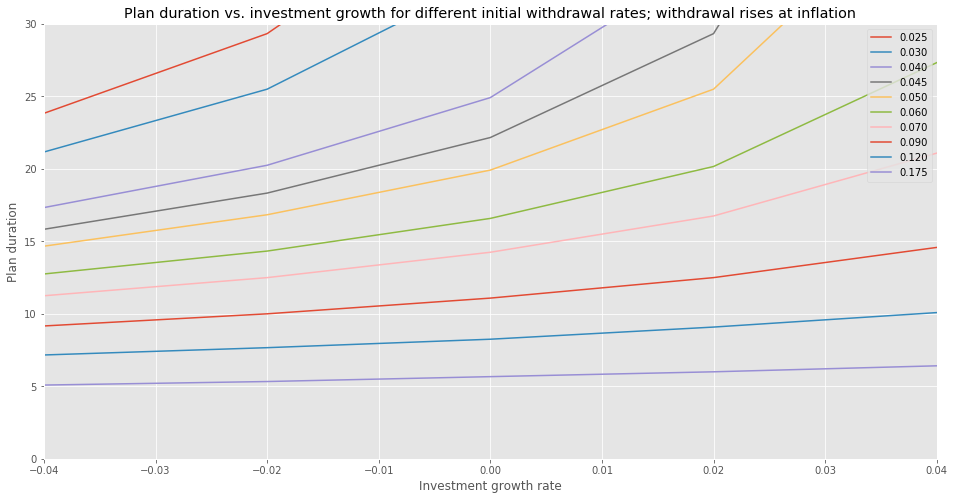

In [68]:
initialsum = -1000000
retire_age = 65
maxyears = 200

scenarios = {
    'g-0.04, w0.00':{'growthrate':-0.04, 'withdrawalrate':0.00},
    'g-0.02, w0.00':{'growthrate':-0.02, 'withdrawalrate':0.00},
    'g0.00, w0.00':{'growthrate':0.00, 'withdrawalrate':0.00},
    'g0.02, w0.00':{'growthrate':0.02, 'withdrawalrate':0.00},
    'g0.04, w0.00':{'growthrate':0.04, 'withdrawalrate':0.00},
}
growthrates = [i['growthrate'] for i in [scenarios[key] for key in scenarios.keys()]]
annualwithdrawals = [0.025, 0.03, 0.04,0.045,0.05,0.06,0.07,0.09,0.12,0.175]

dfSumg,dfAgeEndg,dfDurationg,dfMoneyLeftg,dfFinWithDrg,newbalancename,newagename,newdurationname,withdrawalfinalname\
        = stationaryretirementdepletion(initialsum,retire_age,scenarios,annualwithdrawals,maxyears=maxyears)

dfAgeEndg = pd.pivot_table(dfSumg, index=['Withdrawal0'],values=[newdurationname],columns=['Scenario'])
dfAgeEndg = pd.DataFrame(dfAgeEndg.to_records())
dfAgeEndg.columns = ['Withdrawal0','g-0.02, w0.00','g-0.04, w0.00','g0.00, w0.00','g0.02, w0.00','g0.04, w0.00']
dfAgeEndg = dfAgeEndg[['Withdrawal0','g-0.04, w0.00','g-0.02, w0.00','g0.00, w0.00','g0.02, w0.00','g0.04, w0.00']].transpose()
dfAgeEndg.columns = [f'{i:.3f}' for i in dfAgeEndg.iloc[0]]
dfAgeEndg = dfAgeEndg.iloc[1:]
dfAgeEndg['Growth Rate'] = np.asarray(growthrates).reshape(-1,1) 

display(HTML(dfAgeEndg.to_html()))

figsize(16,8)
fig, axes = plt.subplots(nrows=1, ncols=1)
for icol in dfAgeEndg.columns[:-1]:
    dfAgeEndg.plot(x='Growth Rate',y=icol, ax=axes)    
axes.set_title(f"Plan duration vs. investment growth for different initial withdrawal rates; withdrawal rises at inflation");
axes.set_xlabel('Investment growth rate');
axes.set_ylabel('Plan duration');
axes.set_ylim([0.0,30])
axes.set_xlim([-0.04,0.04]);

It is clear that at high withdrawal rates the investment growth does not have a significant effect on the duration; the money is used up before it can grow.

At 4% initial withdrawal growing only with inflation, the funds are depleted as follows:   
- at investment growth of 2% below inflation: 20 years  
- at investment growth at inflation: 25 years  
- at investment growth of 2% above inflation: 35 years  

To determine the plan duration for withdrawal increases above or below inflation, add or subtract the withdrawal increase from the investment growth rate. For a 4% initial withdrawal, annually increasing above inflation at 4% while the investment grows by 2%, the duration will be given in the above table for -2% investment growth, which is 20 years.


### Withdrawal following market growth

James S. Welch proposes the [strategy](https://www.onefpa.org/journal/Pages/AUG17-A-3-Step-Procedure-for-Computing-Sustainable-Retirement-Savings-Withdrawals.aspx) that withdrawals must follow the market. If the market is down, the withdrawal is also down. Rather suffer the small inconveniences in the short term than the huge crisis in the longer term.

The present model is not at all sufficient to test Welch's procedure but I thought it a good test to compare the duration of a few pensions where the growth in investment equal the growth in withdrawal.  The duration for equal rates the term should be the same.  This is indeed the case in the table below.  On average over the whole term, you can increase the withdrawal rate to the investment growth rate without affecting the term.  You don't need rocket science or a model to come to this conclusion, but it is nice to see.

In [69]:
initialsum = -1000000
retire_age = 65
maxyears = 30

scenarios = {
    'g0.00, w0.00':{'growthrate':0.00, 'withdrawalrate':0.00},
    'g0.01, w0.01':{'growthrate':0.01, 'withdrawalrate':0.01},
    'g0.02, w0.02':{'growthrate':0.02, 'withdrawalrate':0.02},
    'g0.03, w0.03':{'growthrate':0.03, 'withdrawalrate':0.03},
    'g0.04, w0.04':{'growthrate':0.04, 'withdrawalrate':0.04},
}

annualwithdrawals = [0.025, 0.03, 0.04,0.045,0.05,0.06,0.07,0.09,0.12,0.175]

dfSumf,dfAgeEndf,dfDurationf,dfMoneyLeftf,dfFinWithDrf,newbalancename,newagename,newdurationname,withdrawalfinalname\
        = stationaryretirementdepletion(initialsum,retire_age,scenarios,annualwithdrawals,maxyears=maxyears)

In [70]:
display(HTML(dfAgeEndf.to_html()))

### Simple model conclusion

The stationary environment model with averaged rate over the full term shown above provides a ball-park indication of how long the money will last. 
The model does not, however, address real-world issues such as:

1. Stochastic market movement and inflation behaviour. There are real-world and simulated fractal data sets available that can be used to model the markets in simulation.  The validity of the data will be considered later.

1. Antithetical movement between investment growth and inflation.

1. Differentiation of investments into different classes with differing volatilities and risks.

1. Temporal variation in withdrawals, including large lump sum withdrawals, and phased increasing withdrawals towards end of plan.



# All items below this are only sketchy notes at present, to be completed later!

https://www.onefpa.org/journal/Pages/AUG17-A-3-Step-Procedure-for-Computing-Sustainable-Retirement-Savings-Withdrawals.aspx

Van Cilliers gekry:

Analiste waarsku teen ‘n oorvereenvoudigde 4% reël toepassing – daar is heelwat faktore wat jou fondswaarde beïnvloed, soos jy sê. Beide buite jou beheer (soos die JSE) asook binne beheer (soos leefstyl).

1. Die groot uitdaging is die effek van ‘n langdurige beermark wanneer jy aftree, soos tans die geval is. As jy die fondse skuif na ‘n lewende annuïteit om inkomste te trek, realiseer jy die verliese van ‘n paar swak jaar op die JSE – jy besit ‘n groot aantal aandele maar die waarde is laag. Die meeste mense herstel nooit van daardie 20-30% laer as verwagte aanvangswaarde van die lewende annuïteit fondswaarde nie. 40-45 jaar gewerk en die stand van die JSE verdoem jou tot 20 of minder jaar van aftreefondse.

Ek probeer kontantfondse opbou om ‘n jaar of twee van te leef terwyl die pensioenfonds onaangeraak bly en die JSE hopelik herstel. (Hoop is egter ‘n baie power welvaart-strategie met die klomp hansworse wat die ekonomie so bederf.)

2. Belasting is die tweede groot monster wat die leeftyd van die fondswaarde bepaal.

Dit help dat Marieke afgetree is en geen inkomste het nie – ek kan een jaar se leefkoste in haar spaarrekening hou sonder dat belasting die rente opvreet. (Dis die een voordeel van jonger wees as jou vrou. Die waarde van ‘n jonger vrou wat steeds bly werk oortref dit by verre. Aan al hierdie faktore dink mens nie as jy trou op 23 nie!)

Dan is daar ook die opgelope bedrae wat ek in die afgelope paar jaar die toegelate aftrekkings vir pensioenfonds/RA oorskry het – SARS hou self daarvan boek - daardie getal verhoog ook die belastingvrye inkomste wat mens kan trek. As belasting so minimeer word, trek jy minder as 4% en die fonds hou langer.

Kan jy die effek van die progressiewe inkomstebelastingskaal ook in die model inbou? Onttrek al minder en die fonds hou al langer.

3. ‘n Alternatiewe (dalk passiewe) inkomstebron sal ook help dat jy minder onttrek. Bv. ‘n aftree-werk wat bepaalde hoeveelheid inkomste genereer (of natuurlik jou reeks eiendomme).

4. Hoë mediese inflasie, soos jy in die model het. Gesond leef, minimeer mediese uitgawes. Goedkoper mediese plan. Alternatiewe behandelingsmetodes (minder hospitalisasie).

5. Leefstyl-inflasie: Die koste van ons leefstyl se inflasiekoers is aansienlik hoër as die eenvoudige mandjie goedere en dienste wat die regering gebruik, wat tans 4.5% VPI wys. Baie van die goed wat ons gebruik is ingevoer en die invoerbelasting jaag die koste op. Die meeste van ons petrol word ingevoer. 33% van elke liter petrol se koste is belasting.

6. Goedkoper leefstyl. Sal dit help om op die platteland te woon in aftrede? Ons kyk altyd na pryse in die Paarl, maar dit is ook maar maar stadspryse, en eiendom is peperduur. Dieper in die Overberg lyk dit asof mense goedkoper leef. Vriende in Stanford sê hulle leef heelwat goedkoper as in Pretoria. Plaasprodukte sal help. Platteland in die noorde van die land is te veel van ‘n risiko – die golf plundering vanuit die noorde maak dit baie onveilig.

7. Longevity – hoe ouer mens word, hoe groter is die probleem, want dis altyd die laaste 5 jaar wat die meeste geld benodig. Die “frail care” periode met onsekerheid in toekomstige koste. [Ek hoor nou die dag van vriende se 91-jarige ma wat op Polmed medies is – hulle betaal vir 24 uur versorging vir haar, want dis goedkoper as moontlike eise.]

8. Afhanklikes – om te  moet sorg vir ‘n ouer of ‘n kind in jou eie aftrede.

9. Huishoudelike begroting – “live well beneath your means”

10. Fonds-samestelling – die 4% reël veronderstel ten minste 50% in hoë-groei belegging, res in staatseffekte, geldmark, ens. Ek neem aan jy gebruik ‘n lewende annuïteit as opsie, waar jy in die 30 jaar besluite kan neem oor waarin jy belê. Sommige mense dink dis tans beter om te gaan vir die lewens-annuïteit, met ‘n gewaarborgde uitbetaling tot beide eggenotes se sterfte (geen restant word nagelaat aan erfgename nie). Daar is ook nou hibried-opsies wat elemente van beide bevat (dalk net ‘n bemarkingsfoefie?). Die wysigings in die wetgewing op die pensioenbedryf wat 1 Maart 2019 in werking tree speel ook ‘n rol hierin.

11. Aanvulling van fondse. As mens ‘n goeie eiendom het, is die “Reverse Mortgage” ‘n opsie – die bank betaal jou maandeliks ‘n bedrag, wat hulle by sterfte verhaal met die verkoop van die eiendom, sekerllik met goeie rente-inkomste vir hulle. Dit klink na ‘n noodmaatreël eerder as ‘n strategie.

12. Vererwing van boedel. Moet mens beplan om eiendom en geld na te laat aan jou kinders? Die som is makliker as jy aftree-fonds heeltemal kan uitput. As jy net geweet het hoe lank dit moet hou. Dit moet ‘n dinamiese model wees, wat jy elke 6 of 12 maande aanpas met nuwe vooruitskattings.

 